# 2025 CITS4012 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

**Project Overview.** This notebook implements and compares three lightweight Natural Language Inference (NLI) models for scientific question–answer reasoning:
- **Model A:** BiLSTM + Cross-Sentence Attention (TensorFlow/Keras)
- **Model B:** ESIM-Style BiGRU (PyTorch)
- **Model C:** Lightweight Transformer Cross-Encoder (PyTorch)
Each model is trained and evaluated under the same experimental setup.


# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Environment Setup

This cell automatically detects the runtime environment (Google Colab or local) and installs required dependencies accordingly. When running in Colab, packages are installed silently; for local execution, please use `requirements.txt`.


In [1]:
# Environment Setup

import sys

# Detect runtime environment
IS_COLAB = "google.colab" in sys.modules
RUN_LOCAL_OUTPUTS = not IS_COLAB

if IS_COLAB:
    import subprocess
    import importlib

    # List of required packages
    packages = [
        "numpy==1.26.4",
        "pandas==2.2.2",
        "matplotlib==3.8.4",
        "scipy==1.11.4",
        "gensim==4.3.2",
        "pydrive2==1.18.1",
        "tqdm==4.66.4",
        "torch",
        "torchvision",
        "torchaudio",
    ]

    # Perform quiet installation in Colab
    cmd = [sys.executable, "-m", "pip", "install", "--quiet", "--upgrade"] + packages
    print("Detected Colab environment — installing project dependencies...")
    subprocess.check_call(cmd)

    # Clear cached modules to ensure updated versions are loaded
    for module_name in list(sys.modules):
        if module_name.startswith(("numpy", "matplotlib", "pandas", "scipy", "gensim")):
            sys.modules.pop(module_name)
    importlib.invalidate_caches()

else:
    print("Detected Local environment — skipping pip installation (see requirements.txt).")


Detected Colab environment — installing project dependencies...


## Core Imports and Configuration

This cell imports essential libraries (NumPy, Pandas, Matplotlib, scikit-learn) with self-healing capabilities for common version mismatches. It also defines the dataset directory structure and file paths for train/validation/test splits.


In [2]:
# Core Imports and Configuration

import json
import re
import unicodedata
from collections import Counter
from pathlib import Path
from typing import Dict, List, Optional

# ---- NumPy: try import; if ABI error or missing, pin & repair ----
try:
    import numpy as np
    import numpy.core._methods # sanity-check compiled core
except (ModuleNotFoundError, AttributeError, ImportError) as exc:
    import subprocess, sys, importlib
    print("Repairing NumPy / Matplotlib stack:", exc)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "--upgrade",
                            "numpy==1.26.4", "matplotlib==3.8.4"])
    importlib.invalidate_caches()
    # Drop stale modules to ensure fresh import
    for module_name in list(sys.modules):
        if module_name.startswith("numpy") or module_name.startswith("matplotlib"):
            sys.modules.pop(module_name)
    import numpy as np

# ---- Pandas: handle dtype-size mismatch with NumPy ----
try:
    import pandas as pd
except ValueError as exc:
    if "numpy.dtype size changed" in str(exc):
        import subprocess, sys, importlib
        print("Detected NumPy/Pandas mismatch. Reinstalling pinned versions...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "--upgrade",
                                "numpy==1.26.4", "pandas==2.2.2"])
        importlib.invalidate_caches()
        for module_name in list(sys.modules):
            if module_name.startswith("numpy") or module_name.startswith("pandas"):
                sys.modules.pop(module_name)
        import numpy as np
        import pandas as pd
    else:
        raise

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)

# ---- Data root & split file paths ----
DATA_DIR = Path("./data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

DATA_FILES = {
    "train": DATA_DIR / "train.json",
    "validation": DATA_DIR / "validation.json",
    "test": DATA_DIR / "test.json",
}

# Quick visual check in notebooks
DATA_FILES


/tmp/ipython-input-134628936.py:12: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  import numpy as np


{'train': PosixPath('data/train.json'),
 'validation': PosixPath('data/validation.json'),
 'test': PosixPath('data/test.json')}

## Dataset Download (Colab Only)

For Google Colab users, this cell automatically downloads dataset files from Google Drive if they are missing locally. For local execution, ensure JSON files are placed in the `./data/` directory manually.


In [3]:
# Dataset Download (Colab Only)

# ---- Google Drive file IDs for dataset splits ----
GDRIVE_IDS = {
    "train": "1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv",
    "validation": "15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX",
    "test": "179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-",
}

# ---- Attempt to import Colab authentication & PyDrive2 ----
try:
    from google.colab import auth as colab_auth
    from oauth2client.client import GoogleCredentials
    from pydrive2.auth import GoogleAuth
    from pydrive2.drive import GoogleDrive
except ImportError:
    colab_auth = None
    GoogleAuth = None
    GoogleDrive = None
    GoogleCredentials = None

# ---- Ensure dataset splits are available locally ----
def ensure_dataset_files() -> None:
    """Check for missing JSON dataset splits and download them if in Colab."""
    missing = [split for split, path in DATA_FILES.items() if not path.exists()]
    if not missing:
        print("All dataset files already exist locally.")
        return

    # Handle missing files in local environment
    if GoogleDrive is None:
        print(
            "WARNING: Missing splits:",
            ", ".join(missing),
            "-> place the JSON files under",
            DATA_DIR.resolve(),
            "or run this cell inside Google Colab to trigger automatic download.",
        )
        return

    # Perform authenticated download from Google Drive (Colab)
    print("Downloading missing splits:", ", ".join(missing))
    colab_auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    for split in missing:
        file_id = GDRIVE_IDS[split]
        dest_path = DATA_FILES[split]
        dest_path.parent.mkdir(parents=True, exist_ok=True)
        handle = drive.CreateFile({"id": file_id})
        handle.GetContentFile(dest_path.as_posix())
        print(f"Downloaded {split} -> {dest_path}")

# ---- Execute dataset check/download ----
ensure_dataset_files()


All dataset files already exist locally.


## Data Loading and Text Normalization

Load JSON dataset splits into Pandas DataFrames with robust parsing for multiple payload formats. Apply Unicode normalization (NFKC), whitespace folding, lowercase conversion, and character filtering to create clean text fields (`premise_clean`, `hypothesis_clean`).


In [4]:
# Data Loading and Text Normalization

def load_json_as_df(path: Path) -> pd.DataFrame:
    """Load a dataset split from JSON and convert to a flat DataFrame with 'id'."""
    with path.open("r", encoding="utf-8") as stream:
        payload = json.load(stream)

    records = []
    # Case A: { "premise": ..., "hypothesis": ..., "label": ... } (lists or dicts)
    if isinstance(payload, dict) and "premise" in payload and "hypothesis" in payload:
        premise = payload["premise"]
        hypothesis = payload["hypothesis"]
        labels = payload.get("label")

        # A1: premise/hypothesis/label are dicts keyed by index
        if isinstance(premise, dict):
            keys = sorted(premise.keys(), key=int)
            for key in keys:
                record = {
                    "id": int(key),
                    "premise": premise[key],
                    "hypothesis": hypothesis[key],
                }
                if labels is not None:
                    if isinstance(labels, dict):
                        record["label"] = labels.get(key)
                    else:
                        record["label"] = labels[int(key)]
                records.append(record)
        # A2: premise/hypothesis/label are lists aligned by index
        else:
            total = len(premise)
            for idx in range(total):
                record = {
                    "id": idx,
                    "premise": premise[idx],
                    "hypothesis": hypothesis[idx],
                }
                if labels is not None:
                    if isinstance(labels, list):
                        record["label"] = labels[idx]
                    elif isinstance(labels, dict):
                        record["label"] = labels.get(str(idx))
                records.append(record)

    # Case B: payload is a list of item dicts (ensure each has an 'id')
    elif isinstance(payload, list):
        for idx, item in enumerate(payload):
            record = dict(item)
            record.setdefault("id", idx)
            records.append(record)
    else:
        raise ValueError(f"Unsupported payload structure in {path}")

    frame = pd.DataFrame.from_records(records)
    return frame

def normalize(text: Optional[str]) -> str:
    """Normalise text: NFKC, whitespace-folding, lowercase, and allowed-char filtering."""
    if not isinstance(text, str):
        return ""
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    allowed_chars = set("abcdefghijklmnopqrstuvwxyz0123456789.,!?;:'\"()- ")
    text = "".join(ch for ch in text if ch in allowed_chars)
    return text

# ---- Load available splits into frames ----
frames: Dict[str, pd.DataFrame] = {}
for split, path in DATA_FILES.items():
    if path.exists():
        frame = load_json_as_df(path)
        frames[split] = frame
        print(f"Loaded {split}: {len(frame)} rows")
    else:
        print(f"[WARN] {split} split not found at {path}")

# ---- Apply text normalisation to each loaded split ----
for frame in frames.values():
    frame["premise_clean"] = frame["premise"].apply(normalize)
    frame["hypothesis_clean"] = frame["hypothesis"].apply(normalize)

# ---- Expose canonical variables for downstream use ----
train_df = frames.get("train")
val_df = frames.get("validation")
test_df = frames.get("test")

# Quick peek (no-op if train_df is None)
train_df.head() if train_df is not None else None


Loaded train: 23088 rows
Loaded validation: 1304 rows
Loaded test: 2126 rows


,id,premise,hypothesis,label,premise_clean,hypothesis_clean
0,0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,neutral,pluto rotates once on its axis every 6.39 eart...,earth rotates on its axis once times in one day.
1,1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,entails,"---glenn once per day, the earth rotates abou...",earth rotates on its axis once times in one day.
2,2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,neutral,geysers - periodic gush of hot water at the su...,the surface of the sun is much hotter than alm...
3,3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,entails,facts: liquid water droplets can be changed in...,evaporation is responsible for changing liquid...
4,4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,entails,"by comparison, the earth rotates on its axis o...",earth rotates on its axis once times in one day.


## Tokenization and Descriptive Statistics

Tokenize premise and hypothesis texts using a regex-based pattern that captures alphanumeric tokens and punctuation. Compute and display length statistics (mean, median, 95th percentile) and label distributions for each split.


In [5]:
# Tokenization and Descriptive Statistics

TOKEN_PATTERN = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?|[^\w\s]")

def tokenize(text: str) -> List[str]:
    """Lowercase, strip, and split text into tokens using TOKEN_PATTERN."""
    text = (text or "").strip().lower()
    tokens = TOKEN_PATTERN.findall(text)
    return tokens if tokens else ["<empty>"]

def records_from_frame(frame: pd.DataFrame) -> List[Dict[str, Optional[str]]]:
    """Convert a DataFrame into a list of sample dicts with unified fields."""
    samples: List[Dict[str, Optional[str]]] = []
    for row in frame.itertuples(index=False):
        sample = {
            "id": int(getattr(row, "id", len(samples))),
            "premise": getattr(row, "premise_clean", getattr(row, "premise", "")),
            "hypothesis": getattr(row, "hypothesis_clean", getattr(row, "hypothesis", "")),
            "label": getattr(row, "label", None),
        }
        samples.append(sample)
    return samples

def attach_tokens(samples: List[Dict[str, Optional[str]]]) -> None:
    """Attach token lists for premise/hypothesis to each sample in-place."""
    for sample in samples:
        sample["premise_tokens"] = tokenize(sample["premise"])
        sample["hypothesis_tokens"] = tokenize(sample["hypothesis"])

def describe_split(name: str, samples: List[Dict[str, Optional[str]]]) -> Dict[str, float]:
    """Compute and print basic length stats and label distribution for a split."""
    premise_lengths = np.array([len(s["premise_tokens"]) for s in samples])
    hypothesis_lengths = np.array([len(s["hypothesis_tokens"]) for s in samples])
    labels = [s["label"] for s in samples if s.get("label") is not None]

    stats = {
        "num_examples": len(samples),
        "premise_mean": float(premise_lengths.mean()) if len(premise_lengths) else 0.0,
        "premise_median": float(np.median(premise_lengths)) if len(premise_lengths) else 0.0,
        "premise_p95": float(np.percentile(premise_lengths, 95)) if len(premise_lengths) else 0.0,
        "hyp_mean": float(hypothesis_lengths.mean()) if len(hypothesis_lengths) else 0.0,
        "hyp_median": float(np.median(hypothesis_lengths)) if len(hypothesis_lengths) else 0.0,
        "hyp_p95": float(np.percentile(hypothesis_lengths, 95)) if len(hypothesis_lengths) else 0.0,
    }

    print(f"Split: {name}")
    print(f" Examples: {stats['num_examples']}")
    print(f" Premise tokens -> mean {stats['premise_mean']:.1f} | median {stats['premise_median']:.1f} | 95th pct {stats['premise_p95']:.1f}")
    print(f" Hypothesis tokens -> mean {stats['hyp_mean']:.1f} | median {stats['hyp_median']:.1f} | 95th pct {stats['hyp_p95']:.1f}")
    if labels:
        counter = Counter(labels)
        total = sum(counter.values())
        for label, count in counter.items():
            print(f" Label '{label}': {count} ({count / total:.2%})")
    else:
        print(" Labels not provided for this split.")
    print()
    return stats

# ---- Build tokenised samples and report stats for each split ----
dataset_splits: Dict[str, List[Dict[str, Optional[str]]]] = {}
for split, frame in frames.items():
    samples = records_from_frame(frame)
    attach_tokens(samples)
    dataset_splits[split] = samples
    describe_split(split, samples)

# ---- Canonical split handles for downstream use ----
train_samples = dataset_splits.get("train", [])
val_samples = dataset_splits.get("validation", [])
test_samples = dataset_splits.get("test", [])

# ---- Quick preview of the first training sample (if available) ----
if train_samples:
    preview = {
        "premise": train_samples[0]["premise"],
        "hypothesis": train_samples[0]["hypothesis"],
        "label": train_samples[0].get("label"),
        "premise_tokens": train_samples[0]["premise_tokens"][:12],
        "hypothesis_tokens": train_samples[0]["hypothesis_tokens"][:12],
    }
    print("Sample training instance:")
    print(json.dumps(preview, indent=2))


Split: train
 Examples: 23088
 Premise tokens -> mean 20.8 | median 18.0 | 95th pct 38.0
 Hypothesis tokens -> mean 13.2 | median 12.0 | 95th pct 22.0
 Label 'neutral': 14618 (63.31%)
 Label 'entails': 8470 (36.69%)

Split: validation
 Examples: 1304
 Premise tokens -> mean 19.8 | median 17.0 | 95th pct 39.0
 Hypothesis tokens -> mean 13.7 | median 13.0 | 95th pct 23.0
 Label 'neutral': 647 (49.62%)
 Label 'entails': 657 (50.38%)

Split: test
 Examples: 2126
 Premise tokens -> mean 19.3 | median 18.0 | 95th pct 37.0
 Hypothesis tokens -> mean 14.0 | median 13.0 | 95th pct 24.0
 Label 'neutral': 1284 (60.40%)
 Label 'entails': 842 (39.60%)

Sample training instance:
{
  "premise": "pluto rotates once on its axis every 6.39 earth days;",
  "hypothesis": "earth rotates on its axis once times in one day.",
  "label": "neutral",
  "premise_tokens": [
    "pluto",
    "rotates",
    "once",
    "on",
    "its",
    "axis",
    "every",
    "6",
    ".",
    "39",
    "earth",
    "days"
  ],

## Dataset Sample Preview

Display a few training examples to verify data loading and provide a quick inspection of the premise-hypothesis-label structure.


In [6]:
# Dataset Sample Preview

from IPython.display import display
import pandas as pd

# Check whether train_df is available in the workspace
if "train_df" in globals() and train_df is not None:
    # Select available columns safely
    sample_cols = [c for c in ["premise", "hypothesis", "label"] if c in train_df.columns]
    sample_table = train_df.loc[:4, sample_cols].copy()

    # Display sample rows with limited text width
    with pd.option_context("display.max_colwidth", 120):
        display(sample_table)
else:
    print("WARNING: Train split not found — skipping dataset preview.")


,premise,hypothesis,label
0,Pluto rotates once on its axis every 6.39 Earth days;,Earth rotates on its axis once times in one day.,neutral
1,"---Glenn ========================================================= Once per day, the earth rotates about its axis.",Earth rotates on its axis once times in one day.,entails
2,geysers - periodic gush of hot water at the surface of the Earth.,The surface of the sun is much hotter than almost anything on earth.,neutral
3,Facts: Liquid water droplets can be changed into invisible water vapor through a process called evaporation .,Evaporation is responsible for changing liquid water into water vapor.,entails
4,"By comparison, the earth rotates on its axis once per day and revolves around the sun once per year.",Earth rotates on its axis once times in one day.,entails


# 2.Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Model Overview

| Model | Encoder | Sentence Interaction | Pooling | Classifier |
|------:|:--------|:---------------------|:--------|:-----------|
| A | BiLSTM (Keras) | **Cross-sentence attention** (bilinear / dot / none) | max / avg / max+avg | MLP |
| B | BiGRU (PyTorch, ESIM-style) | Soft alignment + local inference + composition | max+avg | MLP |
| C | Transformer (PyTorch, shallow) | Cross-encoder (joint input with delimiter) | [CLS]/max | MLP |

We keep training protocol identical across models unless the architecture demands otherwise.


### Model Suite Summary

- **Model A – BiLSTM + Cross-Attention (Keras):** Encodes premise and hypothesis with BiLSTMs, applies cross-sentence attention variants, and pools joint representations before classification.
- **Model B – ESIM-Style BiGRU (PyTorch):** Performs soft alignment, local inference, and composition with BiGRUs while maintaining an object-oriented dataset/model design.
- **Model C – Lightweight Transformer Cross-Encoder (PyTorch):** Concatenates sentence pairs, runs them through a shallow multi-head self-attention stack, and targets efficiency for Colab runtimes.


In [7]:
# Model Suite Summary

def log_epoch(
    model_name: str,
    epoch: int,
    total_epochs: int,
    train_loss: float,
    train_acc: float,
    val_loss: float,
    val_acc: float,
) -> None:
    """Print a standardised epoch summary line."""
    print(
        f"[{model_name}] Epoch {epoch:02d}/{total_epochs:02d} | "
        f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
    )


---

## Model A: BiLSTM + Cross-Attention (TensorFlow/Keras)

This section implements Model A using TensorFlow/Keras. The architecture includes:
- Bidirectional LSTM encoders for premise and hypothesis
- Cross-sentence attention mechanism (bilinear/dot-product variants)
- Interaction features (absolute difference and element-wise product)
- Pooling strategies (max, average, or concatenated)
- MLP classifier for binary NLI classification

The implementation includes ablation studies on attention types, hidden sizes, and pooling strategies.


### Workflow Overview

- Reuse shared preprocessing and experiment utilities so all models follow the same logging and data pipeline.
- Build the vocabulary from the training split, encode premise/hypothesis sequences, and optionally initialise embeddings with Word2Vec.
- Define the Keras BiLSTM cross-attention architecture with switchable attention, pooling, and hidden-size variants for ablation.
- Train the primary model and its variants, then visualise attention weights to study cross-sentence alignment.


In [8]:
# Model A: BiLSTM + Cross-Attention (TensorFlow/Keras)

try:
    _ = config # noqa: F821 # check if 'config' already exists
except NameError:
    class _EarlyCfg:
        """Minimal fallback configuration used before actual config is defined."""
        pass

    config = _EarlyCfg()

    # Minimal attributes referenced in early cells
    config.num_epochs = 10
    config.batch_size = 32
    config.learning_rate = 1e-3
    config.weight_decay = 1e-5
    config.max_grad_norm = 5.0
    config.hidden_size = 128
    config.dropout = 0.3


In [9]:
# Model A: BiLSTM + Cross-Attention (TensorFlow/Keras)

experiment_configs = []


In [10]:
# Model A: BiLSTM + Cross-Attention (TensorFlow/Keras)

config_A = {
    "model": "Model A (BiLSTM + Cross-Attention)",
    "epochs": 5,
    "batch_size": 64,
    "optimizer": "Adam",
    "learning_rate": 2e-3,
    "lstm_units": 128,
    "dropout": 0.3,
    "max_len": int(max_len) if "max_len" in globals() else None,
}

print("Experiment config (A):", config_A)

# Append to unified experiment registry
experiment_configs.append(config_A)


Experiment config (A): {'model': 'Model A (BiLSTM + Cross-Attention)', 'epochs': 5, 'batch_size': 64, 'optimizer': 'Adam', 'learning_rate': 0.002, 'lstm_units': 128, 'dropout': 0.3, 'max_len': None}


In [11]:
# Model A: BiLSTM + Cross-Attention (TensorFlow/Keras)

from typing import Optional, List

def preprocess_text(text: Optional[str]) -> str:
    """Wrapper around the earlier normaliser to keep behaviour consistent."""
    return normalize(text)

def shared_tokenize(text: str) -> List[str]:
    """Wrapper around the earlier regex-based tokenizer (uses TOKEN_PATTERN)."""
    return tokenize(text)


In [12]:
# Model A: BiLSTM + Cross-Attention (TensorFlow/Keras)

import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---- Fixed random seeds for reproducibility ----
MODEL_A_SEED = 2025
random.seed(MODEL_A_SEED)
np.random.seed(MODEL_A_SEED)
tf.random.set_seed(MODEL_A_SEED)


### Model A: Vocabulary and Sequence Encoding

Build a frequency-based vocabulary from training data (minimum frequency = 2) and encode premise/hypothesis sequences as padded integer arrays. Maximum sequence length is determined by the 90th percentile of token counts (capped at 64).


In [13]:
# Model A: Vocabulary and Sequence Encoding

PAD, UNK = "<PAD>", "<UNK>"

# Use shared regex-based tokenizer for consistency across sections
local_tokenize = shared_tokenize

# ---- Build vocabulary from training split ----
counter = Counter()
for col in ["premise_clean", "hypothesis_clean"]:
    for s in train_df[col]:
        counter.update(local_tokenize(s))

vocab = [PAD, UNK] + [w for w, c in counter.items() if c >= 2]
word2id = {w: i for i, w in enumerate(vocab)}
pad_id, unk_id = word2id[PAD], word2id[UNK]
vocab_size = len(vocab)

# ---- Sequence length heuristic: 90th percentile, capped at 64 ----
lens = [len(local_tokenize(s)) for s in train_df["premise_clean"]] + \
        [len(local_tokenize(s)) for s in train_df["hypothesis_clean"]]
max_len = min(64, int(np.percentile(lens, 90)))
print(f" Vocab size = {vocab_size} | Max len = {max_len}")

# ---- Label mapping ----
label2id = {"entails": 0, "neutral": 1}

def encode(s: str, max_len: int):
    ids = [word2id.get(t, unk_id) for t in local_tokenize(s)]
    return ids[:max_len]

def build_inputs(df: pd.DataFrame):
    P, H, Y = [], [], []
    for _, r in df.iterrows():
        P.append(encode(r["premise_clean"], max_len))
        H.append(encode(r["hypothesis_clean"], max_len))
        Y.append(label2id[r["label"]])
    P = pad_sequences(P, maxlen=max_len, padding="post", value=pad_id)
    H = pad_sequences(H, maxlen=max_len, padding="post", value=pad_id)
    return P, H, np.array(Y)

# ---- Encode all splits ----
Xtr_p, Xtr_h, y_tr = build_inputs(train_df)
Xv_p, Xv_h, y_v = build_inputs(val_df)
Xt_p, Xt_h, y_te = build_inputs(test_df)

# ---- Optionally persist test inputs when running locally ----
results_dir = Path('results')
if RUN_LOCAL_OUTPUTS:
    results_dir.mkdir(exist_ok=True)
    np.savez(results_dir / 'modelA_inputs.npz', Xt_p=Xt_p, Xt_h=Xt_h, y_te=y_te)
else:
    print('[Colab] Skipping saving modelA_inputs.npz')


 Vocab size = 11683 | Max len = 28
[Colab] Skipping saving modelA_inputs.npz


### Model A: Word2Vec Embeddings

Train a 200-dimensional Word2Vec model (skip-gram) on training sentences to initialize token embeddings. Coverage statistics show the percentage of vocabulary tokens with pre-trained vectors.


In [14]:
# Model A: Word2Vec Embeddings

try:
    from gensim.models import Word2Vec
except ImportError as exc:
    if "scipy" in str(exc).lower():
        import subprocess
        import sys
        import importlib
        print("Detected SciPy/Gensim import issue. Reinstalling pinned versions...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "--upgrade", "scipy==1.11.4", "gensim==4.3.2"])
        importlib.invalidate_caches()
        for module_name in list(sys.modules):
            if module_name.startswith(("scipy", "gensim")):
                sys.modules.pop(module_name)
        from gensim.models import Word2Vec
    else:
        raise

# ---- Prepare sentences for W2V training ----
W2V_DIM = 200
sentences = []
for col in ["premise_clean", "hypothesis_clean"]:
    sentences.extend([local_tokenize(s) for s in train_df[col].tolist() if s])

print(f" Training Word2Vec on {len(sentences)} sentences ...")
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=W2V_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,     # skip-gram
    epochs=10
)
wv = w2v_model.wv

def build_embedding_matrix(word2id, wv, dim):
    emb = np.random.normal(scale=0.02, size=(len(word2id), dim)).astype(np.float32)
    emb[pad_id] = 0.0
    hit = 0
    for w, i in word2id.items():
        if w in (PAD, UNK):
            continue
        if w in wv:
            emb[i] = wv[w]
            hit += 1
    print(f" W2V coverage: {hit}/{len(word2id)} = {hit/len(word2id):.1%}")
    return emb

embedding_matrix = build_embedding_matrix(word2id, wv, W2V_DIM)


 Training Word2Vec on 46175 sentences ...
 W2V coverage: 11681/11683 = 100.0%


### Model A: Architecture Definition

Define the BiLSTM + Bilinear Cross-Attention model:
1. **Embedding Layer**: Initialized with Word2Vec vectors (trainable)
2. **BiLSTM Encoders**: Separate encoders for premise and hypothesis
3. **Bi-Affine Attention**: Learnable bilinear weight matrix for cross-sentence attention (scaled by sqrt(d))
4. **Interaction Features**: Concatenate [H, C, |H-C|, H * C] for both sequences
5. **Pooling**: Max + Average pooling over sequence dimension
6. **Classifier**: Two-layer MLP with dropout

An auxiliary attention-fetcher model is also created for visualization purposes.


In [15]:
# Model A: Architecture Definition

class BiAffineCrossAttention(layers.Layer):
    def __init__(self, hidden_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden_dim = hidden_dim

    def build(self, input_shape):
        # Learnable bilinear weight W in R^{D x D}
        self.W = self.add_weight(
            name="bilinear_W",
            shape=(self.hidden_dim, self.hidden_dim),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        Hp, Hh = inputs  # [B,Lp,D], [B,Lh,D]

        # S = Hp * W * Hh^T (bi-affine scores)
        HpW = tf.einsum("bij,jk->bik", Hp, self.W)  # [B,Lp,D]
        S = tf.einsum("bid,bjd->bij", HpW, Hh)  # [B,Lp,Lh]

        # scale by sqrt(d_k) for numerical stability
        scale = tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))
        S = S / tf.maximum(scale, 1.0)

        # Attention distributions (premise->hypothesis, and symmetric)
        Ap = tf.nn.softmax(S, axis=-1)  # [B,Lp,Lh]
        Ah = tf.nn.softmax(tf.transpose(S, (0, 2, 1)), axis=-1)  # [B,Lh,Lp]

        # Contextualised representations via attention
        Cp = tf.einsum("bij,bjd->bid", Ap, Hh)  # [B,Lp,D]
        Ch = tf.einsum("bij,bjd->bid", Ah, Hp)  # [B,Lh,D]
        return Cp, Ch, S

def build_model_A(embedding_matrix, max_len, lstm_units=128, dropout=0.3, lr=2e-3):
    vocab_size, emb_dim = embedding_matrix.shape

    # ---- Inputs ----
    inp_p = layers.Input(shape=(max_len,), name="premise_ids")
    inp_h = layers.Input(shape=(max_len,), name="hypothesis_ids")

    # ---- Token embedding (initialised with Word2Vec) ----
    emb = layers.Embedding(
        input_dim=vocab_size, output_dim=emb_dim,
        weights=[embedding_matrix], trainable=True, mask_zero=False,
        name="tok_emb_w2v"
    )
    Ep, Eh = emb(inp_p), emb(inp_h)

    # ---- Sentence encoders ----
    Hp = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name="bilstm_p")(Ep)
    Hh = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name="bilstm_h")(Eh)
    d = int(Hp.shape[-1])

    # ---- Cross-sentence bi-affine attention ----
    Cp, Ch, S = BiAffineCrossAttention(d, name="cross_attn")([Hp, Hh])

    # ---- Interaction features: |H - C| and H * C (for both sides) ----
    diff_p = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([Hp, Cp])
    prod_p = layers.Multiply()([Hp, Cp])
    Ip = layers.Concatenate(name="inter_p")([Hp, Cp, diff_p, prod_p])

    diff_h = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([Hh, Ch])
    prod_h = layers.Multiply()([Hh, Ch])
    Ih = layers.Concatenate(name="inter_h")([Hh, Ch, diff_h, prod_h])

    # ---- Pooling (max + average) ----
    vp = layers.Concatenate()([layers.GlobalMaxPooling1D()(Ip), layers.GlobalAveragePooling1D()(Ip)])
    vh = layers.Concatenate()([layers.GlobalMaxPooling1D()(Ih), layers.GlobalAveragePooling1D()(Ih)])
    v = layers.Concatenate(name="pair_repr")([vp, vh])

    # ---- Classifier head ----
    v = layers.Dense(256, activation="relu")(v)
    v = layers.Dropout(dropout)(v)
    out = layers.Dense(2, activation="softmax", name="logits")(v)

    # Main classification model
    model = Model([inp_p, inp_h], out, name="ModelA_BiLSTM_BiAffineCrossAttn")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # Auxiliary model to fetch raw attention scores S for visualisation
    S_out = layers.Lambda(lambda x: x, name="attn_scores")(S)
    attn_fetcher = Model([inp_p, inp_h], S_out, name="ModelA_AttnFetcher")
    return model, attn_fetcher

# ---- Build Model A and the attention fetcher ----
modelA, attn_model = build_model_A(embedding_matrix, max_len)
modelA.summary()


Model: "ModelA_BiLSTM_BiAffineCrossAttn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ premise_ids         │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hypothesis_ids      │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tok_emb_w2v         │ (None, 28, 200)   │  2,336,600 │ premise_ids[0][0… │
│ (Embedding)         │                   │            │ hypothesis_ids[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_p            │ (None, 28, 256)   │    336,896 │ tok_emb_w2v[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_h            │ (None, 28, 256)   │    336,896 │ tok_emb_w2v[1][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attn          │ [(None, 28, 256), │     65,536 │ bilstm_p[0][0],   │
│ (BiAffineCrossAtte… │ (None, 28, 256),  │            │ bilstm_h[0][0]    │
│                     │ (None, 28, 28)]   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 28, 256)   │          0 │ bilstm_p[0][0],   │
│                     │                   │            │ cross_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 28, 256)   │          0 │ bilstm_p[0][0],   │
│                     │                   │            │ cross_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 28, 256)   │          0 │ bilstm_h[0][0],   │
│                     │                   │            │ cross_attn[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 28, 256)   │          0 │ bilstm_h[0][0],   │
│ (Multiply)          │                   │            │ cross_attn[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inter_p             │ (None, 28, 1024)  │          0 │ bilstm_p[0][0],   │
│ (Concatenate)       │                   │            │ cross_attn[0][0], │
│                     │                   │            │ lambda[0][0],     │
│                     │                   │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inter_h             │ (None, 28, 1024)  │          0 │ bilstm_h[0][0],   │
│ (Concatenate)       │                   │            │ cross_attn[0][1], │
│                     │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ inter_p[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ inter_p[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ inter_h[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 4,125,274 (15.74 MB)

 Trainable params: 4,125,274 (15.74 MB)

 Non-trainable params: 0 (0.00 B)

### Model A: Ablation Variants

Define configurable model variants for ablation studies:
- **Attention types**: `bilinear` (bi-affine), `dot` (scaled dot-product), `self` (encoder self-attention), `xdecoder` (decoder-style cross-attention), `none` (no attention)
- **Pooling strategies**: `avg`, `max`, `avgmax` (concatenated)
- **Hidden sizes**: 64, 128 (default), etc.

This allows systematic comparison of architectural choices.


In [16]:
# Model A: Ablation Variants

class DotCrossAttention(layers.Layer):
    def call(self, inputs):
        Hp, Hh = inputs
        S = tf.einsum("bid,bjd->bij", Hp, Hh)         # [B,Lp,Lh]
        # scale by sqrt(d_k)
        d = tf.cast(tf.shape(Hp)[-1], tf.float32)
        S = S / tf.maximum(tf.math.sqrt(d), 1.0)
        Ap = tf.nn.softmax(S, axis=-1)
        Ah = tf.nn.softmax(tf.transpose(S, (0,2,1)), axis=-1)
        Cp = tf.einsum("bij,bjd->bid", Ap, Hh)
        Ch = tf.einsum("bij,bjd->bid", Ah, Hp)
        return Cp, Ch, S

def build_model_A_variant(embedding_matrix, max_len,
                          lstm_units=128, dropout=0.3, lr=2e-3,
                          attn_type="bilinear", pooling="avgmax"): # 'bilinear' | 'dot' | 'none' | 'self' | 'xdecoder'
    vocab_size, emb_dim = embedding_matrix.shape

    # ---- Inputs ----
    inp_p = layers.Input(shape=(max_len,), name=f"{attn_type}_premise_ids")
    inp_h = layers.Input(shape=(max_len,), name=f"{attn_type}_hypothesis_ids")

    # ---- Embedding & encoders ----
    emb = layers.Embedding(vocab_size, emb_dim, weights=[embedding_matrix],
                            trainable=True, mask_zero=False, name=f"emb_{attn_type}")
    Ep, Eh = emb(inp_p), emb(inp_h)
    Hp = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name=f"bilstm_p_{attn_type}")(Ep)
    Hh = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True), name=f"bilstm_h_{attn_type}")(Eh)

    # ---- Attention variants ----
    if attn_type == "bilinear":
        d = int(Hp.shape[-1])
        Cp, Ch, S = BiAffineCrossAttention(d, name=f"cross_attn_{attn_type}")([Hp, Hh])
    elif attn_type == "dot":
        Cp, Ch, S = DotCrossAttention(name=f"cross_attn_{attn_type}")([Hp, Hh])
    elif attn_type == "self":
        # Encoder-side self-attention on each sequence using MHA
        num_heads = 4
        key_dim = max(1, int(Hp.shape[-1]) // num_heads)
        mha_self_p = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, name=f"self_mha_p_{attn_type}")
        mha_self_h = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, name=f"self_mha_h_{attn_type}")
        Cp = mha_self_p(query=Hp, value=Hp, key=Hp)
        Ch = mha_self_h(query=Hh, value=Hh, key=Hh)
        S = None
    elif attn_type == "xdecoder":
        # Decoder-style cross-attention: premise queries hypothesis and vice versa
        num_heads = 4
        key_dim = max(1, int(Hp.shape[-1]) // num_heads)
        mha_p_qH = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, name=f"mha_p_qH_{attn_type}")
        mha_h_qP = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, name=f"mha_h_qP_{attn_type}")
        Cp = mha_p_qH(query=Hp, value=Hh, key=Hh)
        Ch = mha_h_qP(query=Hh, value=Hp, key=Hp)
        S = None
    else:
        # 'none' -> no cross/self attention; pass-through encodings
        Cp, Ch = Hp, Hh
        S = None

    # ---- Interaction features ----
    diff_p = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([Hp, Cp])
    prod_p = layers.Multiply()([Hp, Cp])
    Ip = layers.Concatenate()([Hp, Cp, diff_p, prod_p])

    diff_h = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([Hh, Ch])
    prod_h = layers.Multiply()([Hh, Ch])
    Ih = layers.Concatenate()([Hh, Ch, diff_h, prod_h])

    # ---- Pooling selection ----
    if pooling == "avg":
        vp = layers.GlobalAveragePooling1D()(Ip)
        vh = layers.GlobalAveragePooling1D()(Ih)
    elif pooling == "max":
        vp = layers.GlobalMaxPooling1D()(Ip)
        vh = layers.GlobalMaxPooling1D()(Ih)
    else: # 'avgmax'
        vp = layers.Concatenate()([layers.GlobalMaxPooling1D()(Ip), layers.GlobalAveragePooling1D()(Ip)])
        vh = layers.Concatenate()([layers.GlobalMaxPooling1D()(Ih), layers.GlobalAveragePooling1D()(Ih)])

    v = layers.Concatenate(name=f"pair_repr_{attn_type}")([vp, vh])

    # ---- Classifier head ----
    v = layers.Dense(256, activation="relu")(v)
    v = layers.Dropout(dropout)(v)
    out = layers.Dense(2, activation="softmax", name=f"logits_{attn_type}")(v)

    # ---- Compile model ----
    model = Model([inp_p, inp_h], out, name=f"ModelA_{attn_type.upper()}")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # ---- Optional attention fetcher for visualisation ----
    attn_fetcher = None
    if S is not None:
        S_out = layers.Lambda(lambda x: x, name=f"attn_scores_{attn_type}")(S)
        attn_fetcher = Model([inp_p, inp_h], S_out, name=f"AttnFetcher_{attn_type}")

    return model, attn_fetcher


### Model A: Training and Evaluation

Train the baseline bilinear attention model for 5 epochs with batch size 64. Plot training curves (loss and accuracy) and evaluate on validation and test sets. Report accuracy, macro-F1, and detailed classification metrics.


Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7051 - loss: 0.5882 - val_accuracy: 0.7262 - val_loss: 0.5569
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8554 - loss: 0.3364 - val_accuracy: 0.7163 - val_loss: 0.8144
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9047 - loss: 0.2408 - val_accuracy: 0.7301 - val_loss: 0.9614
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9343 - loss: 0.1719 - val_accuracy: 0.7255 - val_loss: 1.0429
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9565 - loss: 0.1177 - val_accuracy: 0.7040 - val_loss: 1.3550


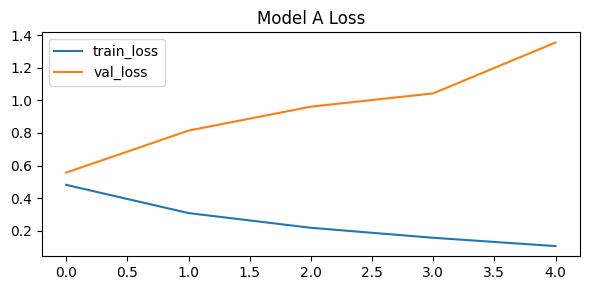

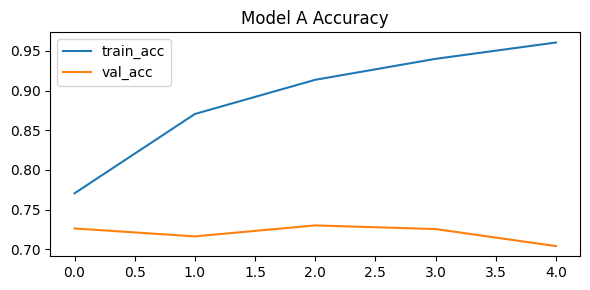

Validation accuracy: 0.7040 | Macro F1: 0.6969
Test accuracy: 0.7140 | Macro F1: 0.6781

 Detailed Validation Report:
               precision    recall  f1-score   support

     entails       0.80      0.55      0.65       657
     neutral       0.65      0.86      0.74       647

    accuracy                           0.70      1304
   macro avg       0.73      0.71      0.70      1304
weighted avg       0.73      0.70      0.70      1304


 Detailed Test Report:
               precision    recall  f1-score   support

     entails       0.70      0.48      0.57       842
     neutral       0.72      0.87      0.79      1284

    accuracy                           0.71      2126
   macro avg       0.71      0.67      0.68      2126
weighted avg       0.71      0.71      0.70      2126



In [17]:
# Model A: Training and Evaluation

history = modelA.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)

modelA_history = history.history

# ---- Simple training curves (loss / accuracy) ----
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))
    plt.plot(modelA_history.get('loss', []), label='train_loss')
    if 'val_loss' in modelA_history:
        plt.plot(modelA_history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Model A Loss'); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    if 'accuracy' in modelA_history:
        plt.plot(modelA_history['accuracy'], label='train_acc')
    if 'val_accuracy' in modelA_history:
        plt.plot(modelA_history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Model A Accuracy'); plt.tight_layout(); plt.show()
except Exception as _:
    pass

# ---- Validation metrics ----
val_pred = np.argmax(modelA.predict([Xv_p, Xv_h], verbose=0), axis=1)
modelA_val_acc = accuracy_score(y_v, val_pred)
modelA_val_f1 = f1_score(y_v, val_pred, average="macro")

# ---- Test metrics ----
test_pred = np.argmax(modelA.predict([Xt_p, Xt_h], verbose=0), axis=1)
modelA_test_acc = accuracy_score(y_te, test_pred)
modelA_test_f1 = f1_score(y_te, test_pred, average="macro")

# ---- Pack results for later aggregation ----
modelA_results = {
    "model_name": "Model A (BiLSTM + Cross-Attention)",
    "val_accuracy": float(modelA_val_acc),
    "test_accuracy": float(modelA_test_acc),
    "val_macro_f1": float(modelA_val_f1),
    "test_macro_f1": float(modelA_test_f1),
}

# ---- Console summary ----
print(f"Validation accuracy: {modelA_val_acc:.4f} | Macro F1: {modelA_val_f1:.4f}")
print(f"Test accuracy: {modelA_test_acc:.4f} | Macro F1: {modelA_test_f1:.4f}")
print("\n Detailed Validation Report:\n", classification_report(y_v, val_pred, target_names=["entails", "neutral"]))
print("\n Detailed Test Report:\n", classification_report(y_te, test_pred, target_names=["entails", "neutral"]))


### Model A: Ablation Study – Attention Mechanisms

Train four attention variants under identical conditions:
1. **No-Attention**: Baseline without cross-sentence interaction
2. **Dot-Attention**: Scaled dot-product attention
3. **Self-Attention**: Encoder-side multi-head self-attention
4. **Decoder-Style Cross-Attention**: Query-key-value cross-attention

This systematic comparison isolates the impact of attention mechanisms on NLI performance.


In [18]:
# Model A: Ablation Study – Attention Mechanisms

# No-Attention baseline
modelA_no, _ = build_model_A_variant(embedding_matrix, max_len, attn_type="none")
print("\n Training No-Attention Variant...")
hist_no = modelA_no.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)

# Dot-Attention variant
modelA_dot, attn_dot = build_model_A_variant(embedding_matrix, max_len, attn_type="dot")
print("\n Training Dot-Attention Variant...")
hist_dot = modelA_dot.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)

# Self-Attention (encoder-side) variant
modelA_self, _ = build_model_A_variant(embedding_matrix, max_len, attn_type="self")
print("\n Training Self-Attention Variant...")
hist_self = modelA_self.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)

# Decoder-style Cross-Attention variant
modelA_xdec, _ = build_model_A_variant(embedding_matrix, max_len, attn_type="xdecoder")
print("\n Training Decoder-Style Cross-Attention Variant...")
hist_xdec = modelA_xdec.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)



 Training No-Attention Variant...
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7087 - loss: 0.5697 - val_accuracy: 0.6733 - val_loss: 0.6316
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8588 - loss: 0.3359 - val_accuracy: 0.7163 - val_loss: 0.8102
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9053 - loss: 0.2360 - val_accuracy: 0.7178 - val_loss: 1.0692
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9361 - loss: 0.1669 - val_accuracy: 0.7255 - val_loss: 0.9947
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9543 - loss: 0.1179 - val_accuracy: 0.7193 - val_loss: 1.5288

 Training Dot-Attention Variant...
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7027 - loss: 0.5855 - val_accuracy: 0.6840 - val_loss: 0.5803
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8553 - loss: 0.3390 - val_accuracy: 0.7293 - val_loss: 0.7446
Epoch 3/5
361/361 ━━━━━━━━━━━━━━

### Model A: Ablation Results – Attention Comparison

Evaluate all attention variants on validation and test sets. Summarize results in a comparative table showing validation accuracy, test accuracy, and macro-F1 scores for each variant.


In [19]:
# Model A: Ablation Results – Attention Comparison

from sklearn.metrics import f1_score

def evaluate_model_variant(model, name):
    """Compute val/test Accuracy and Macro-F1 for a given variant."""
    val_pred = np.argmax(model.predict([Xv_p, Xv_h], verbose=0), axis=1)
    test_pred = np.argmax(model.predict([Xt_p, Xt_h], verbose=0), axis=1)
    return {
        "Model": name,
        "Val Acc": round(accuracy_score(y_v, val_pred), 4),
        "Test Acc": round(accuracy_score(y_te, test_pred), 4),
        "Test F1": round(f1_score(y_te, test_pred, average="macro"), 4),
    }

# ---- Collect results for all variants ----
modelA_variant_rows = [
    evaluate_model_variant(modelA,    "Model A (Bilinear Attn)"),
    evaluate_model_variant(modelA_dot,  "Model A (Dot Attn)"),
    evaluate_model_variant(modelA_no,  "Model A (No Attn)"),
    evaluate_model_variant(modelA_self, "Model A (Self Attn)"),
    evaluate_model_variant(modelA_xdec, "Model A (Decoder-Style X-Attn)"),
]

# ---- Build summary table ----
modelA_variant_df = pd.DataFrame(modelA_variant_rows)
modelA_variant_df.sort_values("Test Acc", ascending=False).reset_index(drop=True)


,Model,Val Acc,Test Acc,Test F1
0,Model A (Decoder-Style X-Attn),0.7316,0.7310,0.7083
1,Model A (Self Attn),0.7009,0.7239,0.6889
2,Model A (No Attn),0.7193,0.7239,0.6957
3,Model A (Bilinear Attn),0.7040,0.7140,0.6781
4,Model A (Dot Attn),0.6994,0.7131,0.6843


### Model A: Ablation Study – Hidden Size

Train a smaller-capacity variant with LSTM hidden size = 64 (vs. default 128) to assess the impact of model capacity on performance.


In [20]:
# Model A: Ablation Study – Hidden Size

modelA_h64, _ = build_model_A_variant(
    embedding_matrix, max_len,
    lstm_units=64, attn_type="bilinear"
)

print("\n Training Bilinear (Hidden = 64) ...")
hist_h64 = modelA_h64.fit(
    [Xtr_p, Xtr_h], y_tr,
    validation_data=([Xv_p, Xv_h], y_v),
    epochs=5, batch_size=64, verbose=1
)

# ---- Evaluate and append to summary ----
row_h64 = evaluate_model_variant(modelA_h64, "Model A (Bilinear, LSTM=64)")
modelA_variant_df = pd.concat(
    [modelA_variant_df, pd.DataFrame([row_h64])],
    ignore_index=True
)

modelA_variant_df



 Training Bilinear (Hidden = 64) ...
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7029 - loss: 0.5718 - val_accuracy: 0.6817 - val_loss: 0.6059
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8573 - loss: 0.3354 - val_accuracy: 0.7224 - val_loss: 0.7528
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9036 - loss: 0.2380 - val_accuracy: 0.7155 - val_loss: 0.9554
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9367 - loss: 0.1685 - val_accuracy: 0.7132 - val_loss: 1.2312
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9521 - loss: 0.1171 - val_accuracy: 0.7032 - val_loss: 1.5082


,Model,Val Acc,Test Acc,Test F1
0,Model A (Bilinear Attn),0.7040,0.7140,0.6781
1,Model A (Dot Attn),0.6994,0.7131,0.6843
2,Model A (No Attn),0.7193,0.7239,0.6957
3,Model A (Self Attn),0.7009,0.7239,0.6889
4,Model A (Decoder-Style X-Attn),0.7316,0.7310,0.7083
5,"Model A (Bilinear, LSTM=64)",0.7032,0.7244,0.7029


### Model A: Ablation Study – Pooling Strategies

Compare three pooling strategies for sequence aggregation:
- **Average pooling**: Mean over sequence dimension
- **Max pooling**: Max over sequence dimension
- **Avg+Max pooling**: Concatenation of both (default)

Results show the effectiveness of combining multiple pooling operations.


In [21]:
# Model A: Ablation Study – Pooling Strategies

rows_pool = []
for pooling in ["avg", "max", "avgmax"]:
    model_pool, _ = build_model_A_variant(
        embedding_matrix, max_len,
        attn_type="bilinear", pooling=pooling
    )
    print(f"\n Training Bilinear with pooling = {pooling} ...")
    _ = model_pool.fit(
        [Xtr_p, Xtr_h], y_tr,
        validation_data=([Xv_p, Xv_h], y_v),
        epochs=5, batch_size=64, verbose=1
    )
    rows_pool.append(
        evaluate_model_variant(model_pool, f"Model A (Bilinear, pooling={pooling})")
    )

# ---- Summarise results ----
pooling_df = pd.DataFrame(rows_pool)
pooling_df.sort_values("Test Acc", ascending=False).reset_index(drop=True)



 Training Bilinear with pooling = avg ...
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7205 - loss: 0.5454 - val_accuracy: 0.6825 - val_loss: 0.6159
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8630 - loss: 0.3296 - val_accuracy: 0.7255 - val_loss: 0.7155
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9053 - loss: 0.2297 - val_accuracy: 0.7163 - val_loss: 1.0234
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9421 - loss: 0.1585 - val_accuracy: 0.7071 - val_loss: 1.2698
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9575 - loss: 0.1073 - val_accuracy: 0.7071 - val_loss: 1.5561

 Training Bilinear with pooling = max ...
Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7123 - loss: 0.5658 - val_accuracy: 0.6979 - val_loss: 0.5927
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8651 - loss: 0.3275 - val_accuracy: 0.7308 - val_loss: 0.7518
Epoch 3/5
361/361

,Model,Val Acc,Test Acc,Test F1
0,"Model A (Bilinear, pooling=avg)",0.7071,0.7173,0.6943
1,"Model A (Bilinear, pooling=max)",0.7071,0.7140,0.6851
2,"Model A (Bilinear, pooling=avgmax)",0.7025,0.7098,0.6817


### Model A: Attention Visualization

Generate attention heatmap for a test example showing premisexhypothesis alignment. The bilinear attention matrix reveals which premise tokens the model attends to for each hypothesis token, providing interpretability for the model's reasoning.


[Colab] Displaying attention heatmap without saving file.


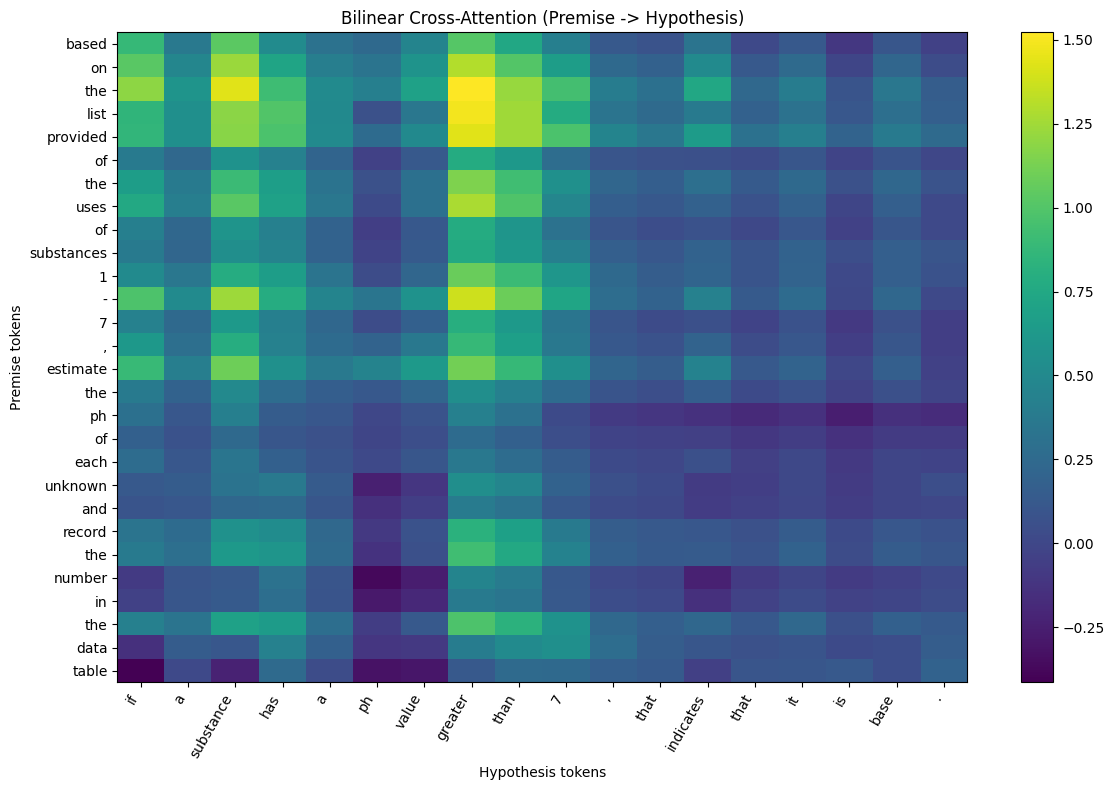

In [22]:
# Model A: Attention Visualization

import sys
import importlib
from pathlib import Path
import numpy as np
from IPython.display import Image, display

def id2tok(seq_ids):
    """Map a sequence of token IDs back to tokens (stop at PAD)."""
    inv = {i: w for w, i in word2id.items()}
    toks = []
    for i in seq_ids:
        if i == pad_id: break
        toks.append(inv.get(int(i), "<UNK>"))
    return toks

# ---- Ensure inputs for plotting are available ----
results_dir = Path('results')
inputs_cache = results_dir / 'modelA_inputs.npz'
if 'Xt_p' not in globals() or 'Xt_h' not in globals():
    if inputs_cache.exists():
        cache = np.load(inputs_cache)
        Xt_p = cache['Xt_p']
        Xt_h = cache['Xt_h']
    elif 'build_inputs' in globals():
        Xt_p, Xt_h, y_te = build_inputs(test_df)
    else:
        raise RuntimeError("Model A inputs are missing; rerun the Model A data preparation cell before plotting.")

# ---- Select a sample and compute attention scores ----
idx = 0
prem_ids = Xt_p[idx:idx+1]
hypo_ids = Xt_h[idx:idx+1]
S = attn_model.predict([prem_ids, hypo_ids], verbose=0)[0]  # [Lp, Lh]

prem_toks = id2tok(prem_ids[0])
hypo_toks = id2tok(hypo_ids[0])

Lp, Lh = len(prem_toks), len(hypo_toks)
S = S[:Lp, :Lh]

# ---- Matplotlib backend handling (Colab/Headless) ----
plt_module = importlib.import_module('matplotlib.pyplot')
if 'google.colab' in sys.modules:
    plt_module.switch_backend('agg')

# ---- Plot heatmap ----
fig = plt_module.figure(figsize=(float(min(12.0, 0.6 * Lh + 3)), float(min(8.0, 0.5 * Lp + 3))))
ax = fig.add_subplot(111)
cax = ax.imshow(S, aspect="auto")
fig.colorbar(cax)
ax.set_xticks(range(Lh))
ax.set_xticklabels(hypo_toks, rotation=60, ha="right")
ax.set_yticks(range(Lp))
ax.set_yticklabels(prem_toks)
ax.set_title("Bilinear Cross-Attention (Premise -> Hypothesis)")
ax.set_xlabel("Hypothesis tokens")
ax.set_ylabel("Premise tokens")
fig.tight_layout()

# ---- Save or display ----
figure_path = results_dir / 'modelA_attention.png'
if RUN_LOCAL_OUTPUTS:
    results_dir.mkdir(exist_ok=True)
    fig.savefig(figure_path, dpi=150, bbox_inches='tight')
    display(Image(filename=str(figure_path)))
else:
    print('[Colab] Displaying attention heatmap without saving file.')
    display(fig)

plt_module.close(fig)


## Model B – ESIM-Style BiGRU with Inference Composition

This section configures the PyTorch ESIM pipeline, trains it with early stopping, reports metrics, and inspects alignment weights before moving on to the next architecture.


### Workflow Overview

- Configure ESIM BiGRU hyperparameters and seeds while reusing the shared text normalisation and tokenisation helpers.
- Load the dataset splits and inspect length/label statistics to guide padding strategy and capacity choices.
- Construct the vocabulary and dynamically padded DataLoaders, trimming infrequent tokens to control embedding size.
- Instantiate the ESIM architecture, run training/validation, and use classification reports plus alignment plots for analysis.


### Model B: Configuration and Environment Setup

Configure Model B hyperparameters (hidden size, dropout, learning rate, etc.) and set up PyTorch environment with reproducible random seeds. Device selection automatically chooses CUDA if available.


In [23]:
# Model B: Configuration and Environment Setup

# Guarded read of a global config; provide fallbacks if executed out of order
try:
    cfg = config # from earlier config cell
except NameError:
    # Fallback defaults to avoid NameError when cells run out of order
    class _TmpCfg:
        pass
    cfg = _TmpCfg()
    cfg.num_epochs = 10
    cfg.batch_size = 32
    cfg.learning_rate = 1e-3
    cfg.weight_decay = 1e-5
    cfg.max_grad_norm = 5.0
    cfg.hidden_size = 128
    cfg.dropout = 0.3

# Consolidated configuration for Model B (ESIM / BiGRU)
config_B = {
    "model": "Model B (ESIM / BiGRU)",
    "epochs": cfg.num_epochs,
    "batch_size": cfg.batch_size,
    "optimizer": "AdamW",
    "learning_rate": cfg.learning_rate,
    "weight_decay": cfg.weight_decay,
    "max_grad_norm": cfg.max_grad_norm,
    "hidden_size": cfg.hidden_size,
    "dropout": cfg.dropout,
}

print("Experiment config (B):", config_B)
experiment_configs.append(config_B)


Experiment config (B): {'model': 'Model B (ESIM / BiGRU)', 'epochs': 10, 'batch_size': 32, 'optimizer': 'AdamW', 'learning_rate': 0.001, 'weight_decay': 1e-05, 'max_grad_norm': 5.0, 'hidden_size': 128, 'dropout': 0.3}


In [24]:
# Model B: Configuration and Environment Setup

import math
import random
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from tqdm.auto import tqdm

# ---- Random seed setup for reproducibility ----
random.seed(2025)
np.random.seed(2025)
torch.manual_seed(2025)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2025)


In [25]:
# Model B: Configuration and Environment Setup

from typing import List

def tokenize(text: str) -> List[str]:
    """Use shared tokenizer for consistency across models."""
    return shared_tokenize(clean_text(text))




### Model B: Data Utilities and Preprocessing

Define core utilities for Model B:
- **Config dataclass**: Centralized hyperparameter management
- **Tokenization**: Regex-based tokenizer (shared with other models)
- **JSON loader**: Robust parser for multiple dataset formats
- **Statistics**: Token length summaries and label distributions


In [26]:
# Model B: Data Utilities and Preprocessing

PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
LABEL_TO_ID = {"entails": 0, "neutral": 1}
ID_TO_LABEL = {v: k for k, v in LABEL_TO_ID.items()}

import json
import numpy as np
from collections import Counter

@dataclass
class Config:
    """Configuration for Model B data pipeline and ESIM hyperparameters."""
    data_dir: Path = Path('.')
    min_freq: int = 2
    max_vocab_size: Optional[int] = 30000
    embed_dim: int = 200
    hidden_size: int = 128
    projection_dim: int = 256
    mlp_dim: int = 256
    dropout: float = 0.3
    batch_size: int = 32
    num_epochs: int = 10
    patience: int = 3
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    max_grad_norm: float = 5.0
    seed: int = 2025

def set_seed(seed: int) -> None:
    """Set seeds across Python/NumPy/PyTorch and configure cuDNN determinism."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def clean_text(text: str) -> str:
    """Lightweight normalisation for Model B (preserve content; trim newlines/spaces)."""
    return text.replace('\n', ' ').strip()

def tokenize(text: str) -> List[str]:
    """Regex-based tokeniser for Model B (lowercase + simple alnum+apostrophe rule)."""
    text = clean_text(text.lower())
    tokens = re.findall(r"[a-z0-9]+(?:'[a-z0-9]+)?|[^\w\s]", text)
    return tokens if tokens else ["<empty>"]

def load_split(path: Path) -> List[Dict[str, Optional[str]]]:
    """Load a split (train/val/test) from JSON (dict or list schema) into record dicts."""
    with path.open('r', encoding='utf-8') as stream:
        payload = json.load(stream)

    # Dict schema: {premise: {i:...}, hypothesis:{i:...}, label: {i:...}|[...]|scalar}
    if isinstance(payload, dict) and 'premise' in payload and 'hypothesis' in payload:
        keys = sorted(payload['premise'].keys(), key=int)
        labels = payload.get('label')
        records: List[Dict[str, Optional[str]]] = []
        for key in keys:
            key_int = int(key)
            record = {
                'id': key_int,
                'premise': payload['premise'][key],
                'hypothesis': payload['hypothesis'][key],
                'label': None,
            }
            if labels is not None:
                if isinstance(labels, dict):
                    record['label'] = labels.get(key) or labels.get(str(key)) or labels.get(key_int)
                elif isinstance(labels, list):
                    record['label'] = labels[key_int]
                else:
                    record['label'] = labels
            records.append(record)
        return records

    # List schema: [{id?, premise, hypothesis, label?}, ...]
    if isinstance(payload, list):
        records = []
        for idx, item in enumerate(payload):
            records.append({
                'id': int(item.get('id', idx)),
                'premise': item['premise'],
                'hypothesis': item['hypothesis'],
                'label': item.get('label'),
            })
        return records

    raise ValueError(f'Unsupported payload structure in {path}')

def attach_tokens(samples: List[Dict[str, Optional[str]]]) -> None:
    """Attach token lists for premise/hypothesis to each sample in-place."""
    for sample in samples:
        sample['premise_tokens'] = tokenize(sample['premise'])
        sample['hypothesis_tokens'] = tokenize(sample['hypothesis'])

def describe_split(name: str, samples: List[Dict[str, Optional[str]]]) -> Dict[str, object]:
    """Compute label counts and token length stats (mean/max/p95) for a split."""
    label_counts = Counter(sample['label'] for sample in samples if sample.get('label') is not None)
    premise_lengths = [len(sample['premise_tokens']) for sample in samples]
    hypothesis_lengths = [len(sample['hypothesis_tokens']) for sample in samples]

    def summarise(lengths: List[int]) -> Dict[str, float]:
        if not lengths:
            return {'mean': 0.0, 'max': 0, 'p95': 0.0}
        return {
            'mean': float(np.mean(lengths)),
            'max': int(max(lengths)),
            'p95': float(np.percentile(lengths, 95)),
        }

    stats = {
        'num_examples': len(samples),
        'label_counts': dict(label_counts),
        'premise_lengths': summarise(premise_lengths),
        'hypothesis_lengths': summarise(hypothesis_lengths),
    }

    print(f"{name.title()} split -> {stats['num_examples']} examples | label counts: {stats['label_counts']}")
    if premise_lengths and hypothesis_lengths:
        print(
            f" Premise tokens: mean={stats['premise_lengths']['mean']:.1f}, max={stats['premise_lengths']['max']}, p95={stats['premise_lengths']['p95']:.1f}"
        )
        print(
            f" Hypothesis tokens: mean={stats['hypothesis_lengths']['mean']:.1f}, max={stats['hypothesis_lengths']['max']}, p95={stats['hypothesis_lengths']['p95']:.1f}"
        )
    return stats


### Model B: Vocabulary and Dataset Classes

Implement PyTorch-compatible data structures:
- **Vocabulary**: Token-to-index mapping with PAD/UNK handling (frequency threshold = 2)
- **NLIDataset**: PyTorch Dataset yielding encoded premise/hypothesis pairs with labels
- **Collate function**: Dynamic padding for variable-length batches


In [27]:
# Model B: Vocabulary and Dataset Classes

class Vocabulary:
    """Token-to-id and id-to-token mapping with PAD/UNK support."""
    def __init__(self, stoi: Dict[str, int]):
        self.stoi = stoi
        self.itos = {idx: token for token, idx in stoi.items()}
        self.pad_id = self.stoi[PAD_TOKEN]
        self.unk_id = self.stoi[UNK_TOKEN]

    @classmethod
    def build(
        cls, samples: Iterable[Dict[str, Optional[str]]],
        min_freq: int = 1, max_size: Optional[int] = None
    ) -> "Vocabulary":
        """Build vocabulary from samples using min_freq and optional max_size."""
        counter: Counter = Counter()
        for sample in samples:
            counter.update(sample["premise_tokens"])
            counter.update(sample["hypothesis_tokens"])

        most_common = [tok for tok, freq in counter.most_common() if freq >= min_freq]
        if max_size is not None:
            capacity = max_size - 2 # reserve PAD/UNK
            most_common = most_common[:max(0, capacity)]

        stoi = {PAD_TOKEN: 0, UNK_TOKEN: 1}
        for token in most_common:
            if token not in stoi:
                stoi[token] = len(stoi)
        return cls(stoi)

    def __len__(self) -> int:
        return len(self.stoi)

    def encode(self, tokens: List[str]) -> List[int]:
        """Convert token list to list of ids."""
        return [self.stoi.get(tok, self.unk_id) for tok in tokens]

    def decode(self, ids: List[int]) -> List[str]:
        """Convert list of ids back to tokens."""
        return [self.itos.get(idx, UNK_TOKEN) for idx in ids]


class NLIDataset(Dataset):
    """Torch Dataset for NLI (premise–hypothesis) pairs."""
    def __init__(self, samples: List[Dict[str, Optional[str]]],
                  vocab: Vocabulary, label_to_id: Dict[str, int]):
        self.vocab = vocab
        self.label_to_id = label_to_id
        self.samples = []
        for sample in samples:
            item = {
                "id": sample["id"],
                "premise_ids": vocab.encode(sample["premise_tokens"]),
                "hypothesis_ids": vocab.encode(sample["hypothesis_tokens"]),
                "premise_text": sample["premise"],
                "hypothesis_text": sample["hypothesis"],
                "label": label_to_id[sample["label"]] if sample["label"] is not None else None,
            }
            self.samples.append(item)

    def __len__(self) -> int:
        return len(self.samples)

    def decode_tokens(self, ids: List[int]) -> List[str]:
        """Utility to decode token ids back to strings."""
        return [self.vocab.itos.get(idx, UNK_TOKEN) for idx in ids]

    def __getitem__(self, idx: int) -> Dict[str, Optional[torch.Tensor]]:
        return self.samples[idx]


def build_collate_fn(pad_id: int):
    """Return a collate_fn that pads sequences and bundles tensors into a batch."""
    def collate_fn(batch: List[Dict[str, Optional[torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        premise_seqs = [torch.tensor(item["premise_ids"], dtype=torch.long) for item in batch]
        hypothesis_seqs = [torch.tensor(item["hypothesis_ids"], dtype=torch.long) for item in batch]

        premise_lengths = torch.tensor([len(seq) for seq in premise_seqs], dtype=torch.long)
        hypothesis_lengths = torch.tensor([len(seq) for seq in hypothesis_seqs], dtype=torch.long)

        padded_premise = pad_sequence(premise_seqs, batch_first=True, padding_value=pad_id)
        padded_hypothesis = pad_sequence(hypothesis_seqs, batch_first=True, padding_value=pad_id)

        labels_list = [item["label"] for item in batch]
        labels = None
        if all(label is not None for label in labels_list):
            labels = torch.tensor(labels_list, dtype=torch.long)

        ids = torch.tensor([item["id"] for item in batch], dtype=torch.long)

        return {
            "premise": padded_premise,
            "premise_lengths": premise_lengths,
            "hypothesis": padded_hypothesis,
            "hypothesis_lengths": hypothesis_lengths,
            "labels": labels,
            "ids": ids,
        }
    return collate_fn


### Model B: ESIM Architecture

Define the ESIM-style BiGRU model with the following pipeline:
1. **Embedding**: Token embeddings with dropout
2. **Encoding**: Bidirectional GRU for premise and hypothesis
3. **Soft Alignment**: Compute similarity matrix and masked softmax attention
4. **Local Inference**: Concatenate [encoded, attended, diff, product] for both sequences
5. **Projection**: Linear transformation with ReLU activation
6. **Composition**: Bidirectional GRU over projected features
7. **Pooling**: Masked mean + max pooling
8. **Classification**: MLP with dropout -> logits

The model optionally returns alignment weights for visualization.


In [28]:
# Model B: ESIM Architecture

class ESIMBiGRU(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        hidden_size: int,
        projection_dim: int,
        mlp_dim: int,
        num_classes: int,
        padding_idx: int,
        dropout: float = 0.3,
    ):
        super().__init__()
        self.padding_idx = padding_idx
        self.hidden_size = hidden_size

        # ---- Embedding ----
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)

        # ---- Encoding (BiGRU) ----
        self.encoder = nn.GRU(embed_dim, hidden_size, batch_first=True, bidirectional=True)

        # ---- Inference projection (concat of 4 parts -> proj) ----
        self.projection = nn.Sequential(
            nn.Linear(hidden_size * 8, projection_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # ---- Composition (BiGRU over projected sequences) ----
        self.composition = nn.GRU(projection_dim, hidden_size, batch_first=True, bidirectional=True)

        # ---- Classifier head (concat pooled reps -> MLP -> logits) ----
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 8, mlp_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes),
        )

        self.dropout = nn.Dropout(dropout)
        self._init_parameters()

    def _init_parameters(self) -> None:
        """Xavier init for embeddings/GRUs/Linear; zero PAD row and biases."""
        nn.init.xavier_uniform_(self.embedding.weight)
        self.embedding.weight.data[self.padding_idx] = 0
        for gru in [self.encoder, self.composition]:
            for name, param in gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)
        for module in self.projection:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    @staticmethod
    def masked_softmax(tensor: torch.Tensor, mask: torch.Tensor, dim: int = -1) -> torch.Tensor:
        """Softmax with masking (masked positions set to -inf before softmax)."""
        mask = mask.to(dtype=torch.bool)
        tensor = tensor.masked_fill(~mask, float('-inf'))
        return torch.softmax(tensor, dim=dim)

    def forward(
        self,
        premise: torch.Tensor,
        hypothesis: torch.Tensor,
        premise_lengths: torch.Tensor,
        hypothesis_lengths: torch.Tensor,
        return_alignments: bool = False,
    ):
        # ---- Padding masks ----
        premise_mask = premise != self.padding_idx
        hypothesis_mask = hypothesis != self.padding_idx

        # ---- Embedding + dropout ----
        premise_embed = self.dropout(self.embedding(premise))
        hypothesis_embed = self.dropout(self.embedding(hypothesis))

        # ---- Encode (BiGRU) ----
        premise_encoded, _ = self.encoder(premise_embed)
        hypothesis_encoded, _ = self.encoder(hypothesis_embed)
        premise_encoded = self.dropout(premise_encoded)
        hypothesis_encoded = self.dropout(hypothesis_encoded)

        # ---- Soft alignment (similarity matrix) ----
        similarity = torch.bmm(premise_encoded, hypothesis_encoded.transpose(1, 2))

        hyp_mask_expanded = hypothesis_mask.unsqueeze(1).expand_as(similarity)
        prem_mask_expanded = premise_mask.unsqueeze(1).expand_as(similarity.transpose(1, 2))
        weight_premise = self.masked_softmax(similarity, hyp_mask_expanded, dim=-1)
        weight_hypothesis = self.masked_softmax(similarity.transpose(1, 2), prem_mask_expanded, dim=-1)

        attended_premise = torch.bmm(weight_premise, hypothesis_encoded)
        attended_hypothesis = torch.bmm(weight_hypothesis, premise_encoded)

        # ---- Local inference composition (concat 4 parts) ----
        premise_combined = torch.cat(
            [
                premise_encoded,
                attended_premise,
                premise_encoded - attended_premise,
                premise_encoded * attended_premise,
            ],
            dim=-1,
        )
        hypothesis_combined = torch.cat(
            [
                hypothesis_encoded,
                attended_hypothesis,
                hypothesis_encoded - attended_hypothesis,
                hypothesis_encoded * attended_hypothesis,
            ],
            dim=-1,
        )

        # ---- Projection ----
        premise_projected = self.projection(premise_combined)
        hypothesis_projected = self.projection(hypothesis_combined)

        # ---- Composition (BiGRU) ----
        premise_composed, _ = self.composition(premise_projected)
        hypothesis_composed, _ = self.composition(hypothesis_projected)

        premise_composed = self.dropout(premise_composed)
        hypothesis_composed = self.dropout(hypothesis_composed)

        # ---- Pooling (masked mean & max) ----
        premise_avg = self.masked_mean(premise_composed, premise_mask)
        hypothesis_avg = self.masked_mean(hypothesis_composed, hypothesis_mask)
        premise_max = self.masked_max(premise_composed, premise_mask)
        hypothesis_max = self.masked_max(hypothesis_composed, hypothesis_mask)

        # ---- Classification ----
        combined = torch.cat([premise_avg, premise_max, hypothesis_avg, hypothesis_max], dim=-1)
        logits = self.classifier(combined)

        if return_alignments:
            return logits, weight_premise, weight_hypothesis
        return logits

    @staticmethod
    def masked_mean(sequence: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """Mean pooling with mask (avoid dividing by zero)."""
        mask = mask.unsqueeze(-1).type_as(sequence)
        masked_seq = sequence * mask
        summed = masked_seq.sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1.0)
        return summed / counts

    @staticmethod
    def masked_max(sequence: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """Max pooling with mask (masked positions -> -inf)."""
        mask = mask.unsqueeze(-1)
        masked_seq = sequence.masked_fill(~mask, float('-inf'))
        return masked_seq.max(dim=1).values


### Model B: Training and Evaluation Functions

Implement training infrastructure:
- **train_epoch**: Single epoch with gradient clipping and metric tracking
- **evaluate_esim**: Validation/test loop with loss and accuracy computation
- **train_model_esim**: Full training with AdamW optimizer, learning rate scheduler (ReduceLROnPlateau), and early stopping (patience = 3)

Best model checkpoint is selected based on validation accuracy.


In [29]:
# Model B: Training and Evaluation Functions

def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    max_grad_norm: float,
) -> Dict[str, float]:
    """Run one training epoch and return {'loss', 'accuracy'}."""
    model.train()
    total_loss = 0.0
    total_examples = 0
    all_preds: List[int] = []
    all_labels: List[int] = []

    for batch in tqdm(dataloader, desc="Train", leave=False):
        optimizer.zero_grad(set_to_none=True)

        premise = batch['premise'].to(device)
        hypothesis = batch['hypothesis'].to(device)
        premise_lengths = batch['premise_lengths'].to(device)
        hypothesis_lengths = batch['hypothesis_lengths'].to(device)
        labels = batch['labels'].to(device)

        logits = model(premise, hypothesis, premise_lengths, hypothesis_lengths)
        loss = criterion(logits, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        batch_size = premise.size(0)
        total_loss += loss.item() * batch_size
        total_examples += batch_size

        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.detach().cpu().tolist())
        all_labels.extend(labels.detach().cpu().tolist())

    avg_loss = total_loss / total_examples
    accuracy = accuracy_score(all_labels, all_preds)
    return {"loss": avg_loss, "accuracy": accuracy}


def evaluate_esim(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Dict[str, float]:
    """Evaluate model; when labels exist, return {'loss','accuracy','labels','predictions'}."""
    model.eval()
    total_loss = 0.0
    total_examples = 0
    all_preds: List[int] = []
    all_labels: List[int] = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            premise = batch['premise'].to(device)
            hypothesis = batch['hypothesis'].to(device)
            premise_lengths = batch['premise_lengths'].to(device)
            hypothesis_lengths = batch['hypothesis_lengths'].to(device)

            labels = batch['labels']
            logits = model(premise, hypothesis, premise_lengths, hypothesis_lengths)

            if labels is not None:
                labels = labels.to(device)
                loss = criterion(logits, labels)
                batch_size = premise.size(0)
                total_loss += loss.item() * batch_size
                total_examples += batch_size
                all_labels.extend(labels.detach().cpu().tolist())

                preds = logits.argmax(dim=-1)
                all_preds.extend(preds.detach().cpu().tolist())
            else:
                preds = logits.argmax(dim=-1)
                all_preds.extend(preds.detach().cpu().tolist())

    metrics = {"predictions": all_preds}
    if total_examples > 0:
        metrics["loss"] = total_loss / total_examples
        metrics["accuracy"] = accuracy_score(all_labels, all_preds)
        metrics["labels"] = all_labels
    return metrics


def train_model_esim(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: Config,
    device: torch.device,
) -> Tuple[nn.Module, List[Dict[str, float]]]:
    """Full ESIM training loop with AdamW, LR scheduler, and early stopping."""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # Optional scheduler: reduce LR on val loss plateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1
    )

    best_state = None
    best_val_accuracy = -math.inf
    epochs_without_improvement = 0
    history: List[Dict[str, float]] = []

    for epoch in range(1, config.num_epochs + 1):
        print(f"Epoch {epoch}/{config.num_epochs}")

        # ---- Train & Eval ----
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, device, config.max_grad_norm)
        val_metrics = evaluate_esim(model, val_loader, criterion, device)

        # ---- Logging ----
        log_entry = {
            'epoch': epoch,
            'train_loss': train_metrics['loss'],
            'train_accuracy': train_metrics['accuracy'],
            'val_loss': val_metrics['loss'],
            'val_accuracy': val_metrics['accuracy'],
        }
        history.append(log_entry)
        print(f" Train -> loss: {train_metrics['loss']:.4f}, accuracy: {train_metrics['accuracy']:.4f}")
        print(f" Val  -> loss: {val_metrics['loss']:.4f}, accuracy: {val_metrics['accuracy']:.4f}")

        # ---- Scheduler step on validation loss ----
        try:
            scheduler.step(val_metrics['loss'])
        except Exception:
            pass

        # ---- Early stopping on best val accuracy ----
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_without_improvement = 0
            print(" New best validation accuracy; checkpoint updated.")
        else:
            epochs_without_improvement += 1
            print(f" No improvement for {epochs_without_improvement} epoch(s).")
            if epochs_without_improvement >= config.patience:
                print(" Early stopping triggered.")
                break
        print()

    # ---- Load best checkpoint ----
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


### Model B: Data Loading and Statistics

Load train/validation/test splits, tokenize all samples, and print descriptive statistics (token counts, label distributions). This provides a data quality check before model training.


In [30]:
# Model B: Data Loading and Statistics

config = Config()
set_seed(config.seed)

# ---- Compute device (CUDA if available) ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from pathlib import Path
config.data_dir = Path('./data')

# ---- (Keep original behaviour) cuDNN benchmarking toggle ----
import torch
torch.backends.cudnn.benchmark = True

# ---- Device selection repeated (kept to preserve original flow) ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- Split file paths ----
train_path = config.data_dir / 'train.json'
val_path  = config.data_dir / 'validation.json'
test_path = config.data_dir / 'test.json'

# ---- Load raw samples ----
train_samples = load_split(train_path)
val_samples  = load_split(val_path)
test_samples = load_split(test_path)

# ---- Attach tokens to each sample ----
for split in (train_samples, val_samples, test_samples):
    attach_tokens(split)

# ---- Descriptive statistics ----
train_stats = describe_split('train', train_samples)
val_stats  = describe_split('validation', val_samples)
test_stats = describe_split('test', test_samples)

# ---- Quick peek at the first training example ----
print("Sample training instance:")
print(json.dumps({
    'premise':  train_samples[0]['premise'],
    'hypothesis': train_samples[0]['hypothesis'],
    'label':   train_samples[0]['label'],
}, indent=2))


Train split -> 23088 examples | label counts: {'neutral': 14618, 'entails': 8470}
 Premise tokens: mean=21.1, max=14638, p95=38.0
 Hypothesis tokens: mean=13.2, max=38, p95=22.0
Validation split -> 1304 examples | label counts: {'neutral': 647, 'entails': 657}
 Premise tokens: mean=19.9, max=59, p95=39.0
 Hypothesis tokens: mean=13.8, max=34, p95=23.0
Test split -> 2126 examples | label counts: {'neutral': 1284, 'entails': 842}
 Premise tokens: mean=19.3, max=56, p95=37.0
 Hypothesis tokens: mean=14.0, max=31, p95=25.0
Sample training instance:
{
  "premise": "Pluto rotates once on its axis every 6.39 Earth days;",
  "hypothesis": "Earth rotates on its axis once times in one day.",
  "label": "neutral"
}


### Model B: Vocabulary Construction and DataLoaders

Build vocabulary from training tokens (min_freq=2, max_size=30K), create PyTorch datasets for all splits, and construct DataLoaders with dynamic padding. Display vocabulary size and batch tensor shapes for verification.


In [31]:
# Model B: Vocabulary Construction and DataLoaders

vocab = Vocabulary.build(train_samples, min_freq=config.min_freq, max_size=config.max_vocab_size)
print(f"Vocabulary size: {len(vocab)} (including pad/unk)")

# ---- Torch Datasets ----
train_dataset = NLIDataset(train_samples, vocab, LABEL_TO_ID)
val_dataset  = NLIDataset(val_samples,  vocab, LABEL_TO_ID)
test_dataset = NLIDataset(test_samples, vocab, LABEL_TO_ID)

# ---- Collate (padding) ----
collate_fn = build_collate_fn(vocab.pad_id)

# ---- DataLoaders ----
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
val_loader  = DataLoader(val_dataset,  batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

# ---- Sanity check: one batch shapes ----
batch_example = next(iter(train_loader))
print('Batch tensor shapes:')
for key, value in batch_example.items():
    if isinstance(value, torch.Tensor):
        print(f" {key}: {tuple(value.size())}")


Vocabulary size: 11447 (including pad/unk)
Batch tensor shapes:
 premise: (32, 40)
 premise_lengths: (32,)
 hypothesis: (32, 21)
 hypothesis_lengths: (32,)
 labels: (32,)
 ids: (32,)


### Model B: Model Training

Instantiate the ESIM BiGRU model and train for up to 10 epochs with early stopping. The training loop includes:
- AdamW optimization with weight decay
- Learning rate reduction on plateau
- Gradient clipping (max_norm=5.0)
- Best checkpoint selection by validation accuracy

Training history is captured for later analysis.


In [32]:
# Model B: Model Training

esim_model = ESIMBiGRU(
    vocab_size=len(vocab),
    embed_dim=config.embed_dim,
    hidden_size=config.hidden_size,
    projection_dim=config.projection_dim,
    mlp_dim=config.mlp_dim,
    num_classes=len(LABEL_TO_ID),
    padding_idx=vocab.pad_id,
    dropout=config.dropout,
)
esim_model = esim_model.to(device)
print(f"Model parameters: {sum(p.numel() for p in esim_model.parameters() if p.requires_grad):,}")

# ---- Train the model and capture the history ----
esim_model, esim_history = train_model_esim(
    esim_model, train_loader, val_loader, config, device
)


Model parameters: 3,364,602
Epoch 1/10


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Eval:   0%|          | 0/41 [00:00<?, ?it/s]

 Train -> loss: 0.4431, accuracy: 0.7924
 Val  -> loss: 0.5732, accuracy: 0.6879
 New best validation accuracy; checkpoint updated.

Epoch 2/10


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Eval:   0%|          | 0/41 [00:00<?, ?it/s]

 Train -> loss: 0.2758, accuracy: 0.8841
 Val  -> loss: 0.6556, accuracy: 0.7247
 New best validation accuracy; checkpoint updated.

Epoch 3/10


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Eval:   0%|          | 0/41 [00:00<?, ?it/s]

 Train -> loss: 0.1895, accuracy: 0.9229
 Val  -> loss: 0.7343, accuracy: 0.7324
 New best validation accuracy; checkpoint updated.

Epoch 4/10


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Eval:   0%|          | 0/41 [00:00<?, ?it/s]

 Train -> loss: 0.0976, accuracy: 0.9631
 Val  -> loss: 0.9894, accuracy: 0.7078
 No improvement for 1 epoch(s).

Epoch 5/10


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Eval:   0%|          | 0/41 [00:00<?, ?it/s]

 Train -> loss: 0.0580, accuracy: 0.9782
 Val  -> loss: 1.3093, accuracy: 0.7017
 No improvement for 2 epoch(s).

Epoch 6/10


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Eval:   0%|          | 0/41 [00:00<?, ?it/s]

 Train -> loss: 0.0281, accuracy: 0.9897
 Val  -> loss: 1.7829, accuracy: 0.7048
 No improvement for 3 epoch(s).
 Early stopping triggered.


In [33]:
# Model B: Model Training

# Qualitative narrative for ESIM attention
import math

def _attention_entropy(weights: np.ndarray) -> float:
    """Shannon entropy of a 1D attention vector (after normalisation)."""
    eps = 1e-12
    p = np.clip(weights, eps, 1.0)
    p = p / p.sum()
    return -float((p * np.log(p)).sum())

def summarise_esim_case(model: ESIMBiGRU, dataset: NLIDataset, index: int, title: str):
    """Print a brief narrative for a single ESIM prediction with alignment stats."""
    model.eval()
    sample = dataset[index]

    prem_ids = torch.tensor(sample['premise_ids'], dtype=torch.long, device=device).unsqueeze(0)
    hyp_ids = torch.tensor(sample['hypothesis_ids'], dtype=torch.long, device=device).unsqueeze(0)

    prem_len = sum(1 for t in sample['premise_ids'] if t != vocab.pad_id)
    hyp_len = sum(1 for t in sample['hypothesis_ids'] if t != vocab.pad_id)

    with torch.no_grad():
        logits, Wp, _ = model(
            prem_ids, hyp_ids,
            torch.tensor([prem_len], device=device),
            torch.tensor([hyp_len], device=device),
            return_alignments=True
        )

    pred = ID_TO_LABEL[int(logits.argmax(dim=-1).item())]
    gold = ID_TO_LABEL[int(sample['label'])] if sample['label'] is not None else 'n/a'

    # Alignment matrix (premise x hypothesis) for the selected example
    A = Wp[0, :prem_len, :hyp_len].cpu().numpy()
    row_ent = np.array([_attention_entropy(r) for r in A])
    col_ent = np.array([_attention_entropy(c) for c in A.T])

    premise_tokens  = dataset.decode_tokens(sample['premise_ids'])[:prem_len]
    hypothesis_tokens = dataset.decode_tokens(sample['hypothesis_ids'])[:hyp_len]

    # Top attending hypothesis tokens overall
    col_mass = A.sum(axis=0)
    top_h_idx = col_mass.argsort()[-3:][::-1]
    top_h_tokens = [hypothesis_tokens[i] for i in top_h_idx]

    print(f"[{title}] pred={pred} | gold={gold}")
    print(f" Attention concentration (premise rows entropy mean +/- std): {row_ent.mean():.3f} +/- {row_ent.std():.3f}")
    print(f" Attention concentration (hypothesis cols entropy mean +/- std): {col_ent.mean():.3f} +/- {col_ent.std():.3f}")
    print(f" Top attended hypothesis tokens: {top_h_tokens}")

# ---- Try to narrate one correct and one incorrect case if labels available ----
if 'esim_test_metrics' in globals() and 'labels' in esim_test_metrics and esim_test_metrics['labels']:
    corr_idx, wrong_idx = _select_esim_indices(esim_test_metrics['predictions'], esim_test_metrics['labels'])
    if corr_idx is not None:
        summarise_esim_case(esim_model, test_dataset, corr_idx, 'ESIM correct')
    if wrong_idx is not None:
        summarise_esim_case(esim_model, test_dataset, wrong_idx, 'ESIM wrong')
else:
    print('ESIM qualitative narrative skipped (no test labels).')


ESIM qualitative narrative skipped (no test labels).


In [34]:
# Model B: Model Training

import matplotlib.pyplot as plt
import numpy as np

def _pick_example_by_correctness(model: ESIMBiGRU, loader: DataLoader, want_correct: bool) -> dict:
    """Return the first batch item where prediction matches (or mismatches) the label."""
    model.eval()
    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch['premise'].to(device),
                batch['hypothesis'].to(device),
                batch['premise_lengths'].to(device),
                batch['hypothesis_lengths'].to(device),
            )
            preds = logits.argmax(dim=-1).cpu()
            labels = batch['labels']
            mask = (preds == labels) if want_correct else (preds != labels)
            for i in range(len(labels)):
                if mask[i]:
                    return {k: (v[i] if isinstance(v, torch.Tensor) else v[i]) for k, v in batch.items()}
    return None

def _plot_alignment(weights: torch.Tensor, prem_tokens: list, hyp_tokens: list, title: str):
    """Plot attention matrix with token tick labels."""
    W = weights[:len(prem_tokens), :len(hyp_tokens)].cpu().numpy()
    plt.figure(figsize=(min(12, 0.6*len(hyp_tokens)+3), min(8, 0.5*len(prem_tokens)+3)))
    plt.imshow(W, aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(hyp_tokens)), hyp_tokens, rotation=60, ha='right')
    plt.yticks(range(len(prem_tokens)), prem_tokens)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- Fetch one correct and one incorrect example if available ----
correct_sample = _pick_example_by_correctness(esim_model, val_loader, True)
wrong_sample  = _pick_example_by_correctness(esim_model, val_loader, False)

# ---- Compute alignment weights via forward pass with return_alignments=True ----
esim_model.eval()
with torch.no_grad():
    if correct_sample is not None:
        logits, Wp, Wh = esim_model(
            correct_sample['premise'].unsqueeze(0).to(device),
            correct_sample['hypothesis'].unsqueeze(0).to(device),
            torch.tensor([int(correct_sample['premise_lengths'])]).to(device),
            torch.tensor([int(correct_sample['hypothesis_lengths'])]).to(device),
            return_alignments=True,
        )
        prem_tokens = train_dataset.decode_tokens(correct_sample['premise'].tolist())
        hyp_tokens = train_dataset.decode_tokens(correct_sample['hypothesis'].tolist())
        _plot_alignment(Wp[0], prem_tokens, hyp_tokens, 'ESIM Attention (Correct Case)')

    if wrong_sample is not None:
        logits, Wp, Wh = esim_model(
            wrong_sample['premise'].unsqueeze(0).to(device),
            wrong_sample['hypothesis'].unsqueeze(0).to(device),
            torch.tensor([int(wrong_sample['premise_lengths'])]).to(device),
            torch.tensor([int(wrong_sample['hypothesis_lengths'])]).to(device),
            return_alignments=True,
        )
        prem_tokens = train_dataset.decode_tokens(wrong_sample['premise'].tolist())
        hyp_tokens = train_dataset.decode_tokens(wrong_sample['hypothesis'].tolist())
        _plot_alignment(Wp[0], prem_tokens, hyp_tokens, 'ESIM Attention (Wrong Case)')


### Model B: Training History Summary

Display epoch-by-epoch training and validation metrics with the best epoch highlighted. This allows inspection of convergence behavior and early stopping effectiveness.


In [35]:
# Model B: Training History Summary

print("Training history (best epoch highlighted):")

# Identify best epoch by highest validation accuracy
best_epoch = max(esim_history, key=lambda x: x['val_accuracy'])['epoch']

# Pretty-print history table
for record in esim_history:
    marker = '***' if record['epoch'] == best_epoch else '  '
    print(
        f"{marker} Epoch {record['epoch']:02d} | "
        f"Train loss {record['train_loss']:.4f} | "
        f"Train acc {record['train_accuracy']:.4f} | "
        f"Val loss {record['val_loss']:.4f} | "
        f"Val acc {record['val_accuracy']:.4f}"
    )


Training history (best epoch highlighted):
   Epoch 01 | Train loss 0.4431 | Train acc 0.7924 | Val loss 0.5732 | Val acc 0.6879
   Epoch 02 | Train loss 0.2758 | Train acc 0.8841 | Val loss 0.6556 | Val acc 0.7247
*** Epoch 03 | Train loss 0.1895 | Train acc 0.9229 | Val loss 0.7343 | Val acc 0.7324
   Epoch 04 | Train loss 0.0976 | Train acc 0.9631 | Val loss 0.9894 | Val acc 0.7078
   Epoch 05 | Train loss 0.0580 | Train acc 0.9782 | Val loss 1.3093 | Val acc 0.7017
   Epoch 06 | Train loss 0.0281 | Train acc 0.9897 | Val loss 1.7829 | Val acc 0.7048


### Model B: Validation and Test Evaluation

Evaluate the trained ESIM model on validation and test sets. Print detailed classification reports (precision, recall, F1 per class), confusion matrices, and compute macro-averaged F1 scores for comparison with other models.


In [36]:
# Model B: Validation and Test Evaluation

criterion = nn.CrossEntropyLoss()

# ---- Validation evaluation ----
esim_val_metrics = evaluate_esim(esim_model, val_loader, criterion, device)
print("Validation report:")
esim_val_f1 = None

if 'labels' in esim_val_metrics:
    print(classification_report(
        esim_val_metrics['labels'],
        esim_val_metrics['predictions'],
        target_names=[ID_TO_LABEL[i] for i in range(len(LABEL_TO_ID))],
    ))
    val_confusion = confusion_matrix(
        esim_val_metrics['labels'],
        esim_val_metrics['predictions'],
    )
    print("Validation confusion matrix:")
    print(val_confusion)
    esim_val_f1 = f1_score(
        esim_val_metrics['labels'],
        esim_val_metrics['predictions'],
        average="macro",
    )
else:
    print("Validation split lacks labels; skipping detailed metrics.")

# ---- Test evaluation ----
esim_test_metrics = evaluate_esim(esim_model, test_loader, criterion, device)
print("\nTest report:")
esim_test_f1 = None

if 'labels' in esim_test_metrics:
    print(classification_report(
        esim_test_metrics['labels'],
        esim_test_metrics['predictions'],
        target_names=[ID_TO_LABEL[i] for i in range(len(LABEL_TO_ID))],
    ))
    test_confusion = confusion_matrix(
        esim_test_metrics['labels'],
        esim_test_metrics['predictions'],
    )
    print("Test confusion matrix:")
    print(test_confusion)
    esim_test_f1 = f1_score(
        esim_test_metrics['labels'],
        esim_test_metrics['predictions'],
        average="macro",
    )
else:
    print("Test split has no labels; generated predictions for offline evaluation.")

# ---- Consolidate ESIM evaluation summary ----
esim_results = {
    "model_name": "Model B (ESIM / BiGRU)",
    "val_accuracy": float(esim_val_metrics.get("accuracy", float("nan"))),
    "test_accuracy": float(esim_test_metrics.get("accuracy", float("nan"))),
    "val_macro_f1": float(esim_val_f1) if esim_val_f1 is not None else None,
    "test_macro_f1": float(esim_test_f1) if esim_test_f1 is not None else None,
}


Eval:   0%|          | 0/41 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

     entails       0.74      0.73      0.73       657
     neutral       0.73      0.74      0.73       647

    accuracy                           0.73      1304
   macro avg       0.73      0.73      0.73      1304
weighted avg       0.73      0.73      0.73      1304

Validation confusion matrix:
[[477 180]
 [169 478]]


Eval:   0%|          | 0/67 [00:00<?, ?it/s]


Test report:
              precision    recall  f1-score   support

     entails       0.63      0.63      0.63       842
     neutral       0.76      0.75      0.76      1284

    accuracy                           0.71      2126
   macro avg       0.69      0.69      0.69      2126
weighted avg       0.71      0.71      0.71      2126

Test confusion matrix:
[[533 309]
 [317 967]]


### Model B: Token-Level Alignment Inspection

Display detailed token-to-token alignment for a single validation example. For each hypothesis token, show the top-3 attended premise tokens with attention weights. This provides fine-grained insight into the soft alignment mechanism.


In [37]:
# Model B: Token-Level Alignment Inspection

def show_alignment(model: ESIMBiGRU, dataset: NLIDataset, index: int) -> None:
    model.eval()
    sample = dataset[index]
    with torch.no_grad():
        batch = {
            "premise": torch.tensor(sample["premise_ids"], dtype=torch.long, device=device).unsqueeze(0),
            "hypothesis": torch.tensor(sample["hypothesis_ids"], dtype=torch.long, device=device).unsqueeze(0),
            "premise_lengths": torch.tensor([len(sample["premise_ids"])], dtype=torch.long, device=device),
            "hypothesis_lengths": torch.tensor([len(sample["hypothesis_ids"])], dtype=torch.long, device=device),
        }
        logits, weight_premise, weight_hypothesis = model(
            batch["premise"], batch["hypothesis"],
            batch["premise_lengths"], batch["hypothesis_lengths"],
            return_alignments=True
        )
        predicted = logits.argmax(dim=-1).item()

    premise_tokens = dataset.decode_tokens(sample["premise_ids"])
    hypothesis_tokens = dataset.decode_tokens(sample["hypothesis_ids"])

    print(f"Example ID: {sample['id']}")
    print(f"Premise: {' '.join(premise_tokens)}")
    print(f"Hypothesis: {' '.join(hypothesis_tokens)}")
    print(f"Predicted label: {ID_TO_LABEL[predicted]} | Gold label: {ID_TO_LABEL[sample['label']] if sample['label'] is not None else 'n/a'}")
    print()

    alignment = weight_premise.squeeze(0).cpu().numpy()
    for i, hyp_token in enumerate(hypothesis_tokens):
        attention_row = alignment[:, i]
        top_indices = attention_row.argsort()[-3:][::-1]
        top_pairs = [(premise_tokens[j], attention_row[j]) for j in top_indices]
        formatted = ", ".join(f"{tok}:{score:.3f}" for tok, score in top_pairs)
        print(f"Hypothesis token '{hyp_token}' attends to -> {formatted}")

# Example usage
show_alignment(esim_model, val_dataset, index=0)


Example ID: 0
Premise: an introduction to atoms and elements , compounds , atomic structure and bonding , the molecule and chemical reactions .
Hypothesis: replace another in a molecule happens to atoms during a substitution reaction .
Predicted label: neutral | Gold label: neutral

Hypothesis token 'replace' attends to -> molecule:0.106, the:0.102, ,:0.084
Hypothesis token 'another' attends to -> molecule:0.105, and:0.085, the:0.081
Hypothesis token 'in' attends to -> ,:0.078, introduction:0.076, the:0.076
Hypothesis token 'a' attends to -> molecule:0.089, the:0.083, chemical:0.076
Hypothesis token 'molecule' attends to -> molecule:0.138, chemical:0.097, and:0.097
Hypothesis token 'happens' attends to -> elements:0.156, introduction:0.139, and:0.132
Hypothesis token 'to' attends to -> elements:0.103, bonding:0.098, introduction:0.096
Hypothesis token 'atoms' attends to -> ,:0.099, bonding:0.098, compounds:0.097
Hypothesis token 'during' attends to -> reactions:0.094, atomic:0.088, the

In [38]:
# Model B: Token-Level Alignment Inspection

import matplotlib.pyplot as plt
import numpy as np

def _plot_esim_attention_heatmap(model: ESIMBiGRU, dataset: NLIDataset, index: int, title: str) -> None:
    """Render an ESIM attention heatmap for a single dataset item."""
    model.eval()
    sample = dataset[index]

    # ---- Tensors & lengths ----
    premise_tensor  = torch.tensor(sample['premise_ids'],  dtype=torch.long, device=device).unsqueeze(0)
    hypothesis_tensor = torch.tensor(sample['hypothesis_ids'], dtype=torch.long, device=device).unsqueeze(0)
    prem_len = sum(1 for tok in sample['premise_ids']  if tok != vocab.pad_id)
    hyp_len = sum(1 for tok in sample['hypothesis_ids'] if tok != vocab.pad_id)
    premise_lengths  = torch.tensor([prem_len], dtype=torch.long, device=device)
    hypothesis_lengths = torch.tensor([hyp_len], dtype=torch.long, device=device)

    # ---- Forward with alignments ----
    with torch.no_grad():
        logits, weight_premise, _ = model(
            premise_tensor, hypothesis_tensor,
            premise_lengths, hypothesis_lengths,
            return_alignments=True,
        )

    pred_label = ID_TO_LABEL[int(logits.argmax(dim=-1).item())]
    gold_label = ID_TO_LABEL[int(sample['label'])] if sample['label'] is not None else 'n/a'

    # ---- Tokens & attention submatrix ----
    premise_tokens  = dataset.decode_tokens(sample['premise_ids'])[:prem_len]
    hypothesis_tokens = dataset.decode_tokens(sample['hypothesis_ids'])[:hyp_len]
    attn_matrix = weight_premise[0, :prem_len, :hyp_len].detach().cpu().numpy()

    # ---- Plot ----
    fig_width = min(12, 0.6 * len(hypothesis_tokens) + 3)
    fig_height = min(8, 0.5 * len(premise_tokens)  + 3)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    im = ax.imshow(attn_matrix, aspect='auto', cmap='magma')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(hypothesis_tokens)))
    ax.set_xticklabels(hypothesis_tokens, rotation=60, ha='right')
    ax.set_yticks(range(len(premise_tokens)))
    ax.set_yticklabels(premise_tokens)
    ax.set_xlabel('Hypothesis tokens')
    ax.set_ylabel('Premise tokens')
    ax.set_title(f"{title} (pred: {pred_label} | gold: {gold_label})")
    fig.tight_layout()
    plt.show()

def _select_esim_indices(predictions, labels):
    """Return one correct and one incorrect index (if available)."""
    correct_idx = None
    incorrect_idx = None
    for i, (pred, label) in enumerate(zip(predictions, labels)):
        if correct_idx  is None and pred == label: correct_idx = i
        if incorrect_idx is None and pred != label: incorrect_idx = i
        if correct_idx is not None and incorrect_idx is not None:
            break
    return correct_idx, incorrect_idx

# ---- Drive visualisation from test metrics ----
if 'labels' in esim_test_metrics and esim_test_metrics['labels']:
    correct_idx, incorrect_idx = _select_esim_indices(
        esim_test_metrics['predictions'], esim_test_metrics['labels']
    )
    if correct_idx is not None:
        _plot_esim_attention_heatmap(esim_model, test_dataset, correct_idx, title=f"Test sample #{correct_idx} (correct)")
    if incorrect_idx is not None:
        _plot_esim_attention_heatmap(esim_model, test_dataset, incorrect_idx, title=f"Test sample #{incorrect_idx} (incorrect)")
    if correct_idx is None and incorrect_idx is None:
        print('Unable to locate suitable test samples for attention visualisation.')
else:
    print('Test labels unavailable; skipping Model B qualitative visualisation.')


**Model B attention insight.** The heatmaps illustrate how the ESIM alignment focuses on key science terms (rows = premise tokens, columns = hypothesis tokens). In the correct case the mass concentrates on semantically aligned words, whereas the misclassified example shows diffuse attention over unrelated tokens.

## Model C – Lightweight Transformer Cross-Encoder

Set up the transformer cross-encoder workflow, execute training with warmup scheduling, and capture evaluation artefacts prior to exporting predictions.


### Workflow Overview

- Load the three JSON splits and normalise records with the shared tokenizer/cleaning utilities.
- Build the Transformer vocabulary with token/segment/position encodings while enforcing a max sequence length for the runtime budget.
- Define the shallow multi-head cross-encoder that processes `[CLS] premise [SEP] hypothesis` sequences to produce logits.
- Train and validate with AdamW plus warmup, capturing per-class metrics and exporting artefacts for later reporting.


### Model C: Configuration

Define Model C hyperparameters through a dataclass:
- Transformer architecture: 3 layers, 4 attention heads, 256 embedding dimensions
- Training: 8 epochs, batch size 32, AdamW optimizer (lr=2e-4, weight_decay=1e-4)
- Warmup: 10% of total steps with linear warmup/decay schedule
- Sequence length: max 256 tokens (premise + hypothesis + delimiters)


In [39]:
# Model C: Configuration

# Append Model C config to unified experiment config list
try:
    from dataclasses import asdict
    experiment_configs.append({
        "model": "Model C (Transformer Cross-Encoder)",
        **asdict(config),
    })
    print("Experiment config (C) appended.")
except Exception as exc:
    print("Skip appending Model C config:", exc)


Experiment config (C) appended.


In [40]:
# Model C: Configuration

from dataclasses import asdict

config_C = {
    "model": "Model C (Transformer Cross-Encoder)",
    **asdict(config),
}

print("Experiment config (C):", config_C)
# Note: config_C has already been appended to `experiment_configs` earlier;
# this block simply displays it for clarity and prevents duplication.


Experiment config (C): {'model': 'Model C (Transformer Cross-Encoder)', 'data_dir': PosixPath('data'), 'min_freq': 2, 'max_vocab_size': 30000, 'embed_dim': 200, 'hidden_size': 128, 'projection_dim': 256, 'mlp_dim': 256, 'dropout': 0.3, 'batch_size': 32, 'num_epochs': 10, 'patience': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'max_grad_norm': 5.0, 'seed': 2025}


In [41]:
# Model C: Configuration

from dataclasses import dataclass, asdict
import copy
from typing import Dict, List, Optional, Tuple

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


In [42]:
# Model C: Configuration

def set_seed(seed: int) -> None:
    """Set global random seeds across random, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


@dataclass
class ModelCConfig:
    """Configuration for Model C (Transformer Cross-Encoder)."""
    data_dir: Path = Path("..")
    train_file: str = "train.json"
    val_file: str = "validation.json"
    test_file: str = "test.json"
    max_length: int = 256
    min_freq: int = 2
    embedding_dim: int = 256
    num_heads: int = 4
    num_layers: int = 3
    feedforward_dim: int = 512
    dropout: float = 0.1
    batch_size: int = 32
    num_epochs: int = 8
    lr: float = 2e-4
    weight_decay: float = 1e-4
    max_grad_norm: float = 1.0
    warmup_ratio: float = 0.1
    seed: int = 2025

    @property
    def device(self) -> str:
        """Return 'cuda' if available, else 'cpu'."""
        return "cuda" if torch.cuda.is_available() else "cpu"


# ---- Instantiate configuration and seed environment ----
config = ModelCConfig()

# Optional flag: freeze token embeddings during training
if not hasattr(config, "freeze_token_embedding"):
    config.freeze_token_embedding = False

set_seed(config.seed)
print(f"Using device: {config.device}")
print(f"Configuration: {asdict(config)}")


Using device: cuda
Configuration: {'data_dir': PosixPath('..'), 'train_file': 'train.json', 'val_file': 'validation.json', 'test_file': 'test.json', 'max_length': 256, 'min_freq': 2, 'embedding_dim': 256, 'num_heads': 4, 'num_layers': 3, 'feedforward_dim': 512, 'dropout': 0.1, 'batch_size': 32, 'num_epochs': 8, 'lr': 0.0002, 'weight_decay': 0.0001, 'max_grad_norm': 1.0, 'warmup_ratio': 0.1, 'seed': 2025}


### Model C: Data Loading and Statistics

Load dataset splits, apply basic tokenization, and compute descriptive statistics:
- Sample counts per split
- Label distribution (train)
- Combined token length statistics (premise + hypothesis)

These metrics inform max_length selection and provide a baseline understanding of data characteristics.


In [43]:
# Model C: Data Loading and Statistics

TOKEN_PATTERN = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?|[^\w\s]")

def basic_tokenize(text: str) -> List[str]:
    """Simple regex tokenizer for lowercase alphanumeric tokens and punctuation."""
    text = text.strip().lower()
    return TOKEN_PATTERN.findall(text)

def load_split(file_path: Path) -> List[Dict[str, Optional[str]]]:
    """Load a JSON NLI split and return a list of dict records."""
    with file_path.open() as stream:
        payload = json.load(stream)

    keys = sorted(payload["premise"].keys(), key=int)
    label_data = payload.get("label")
    records: List[Dict[str, Optional[str]]] = []

    for key in keys:
        label: Optional[str] = None
        if label_data is not None:
            if isinstance(label_data, dict):
                label = label_data.get(key)
            else:
                label = label_data[int(key)]
        records.append({
            "id": key,
            "premise": payload["premise"][key],
            "hypothesis": payload["hypothesis"][key],
            "label": label,
        })

    return records

def preprocess_records(records: List[Dict[str, Optional[str]]]) -> None:
    """Attach tokenised premise/hypothesis fields to each record."""
    for item in records:
        item["premise_tokens"] = basic_tokenize(item["premise"])
        item["hypothesis_tokens"] = basic_tokenize(item["hypothesis"])


In [44]:
# Model C: Data Loading and Statistics

from pathlib import Path

# ---- Data directory setup ----
config.data_dir = Path('./data')
data_root = config.data_dir

# ---- Load dataset splits ----
train_records = load_split(data_root / config.train_file)
val_records  = load_split(data_root / config.val_file)
test_records = load_split(data_root / config.test_file)

# ---- Tokenise and summarise ----
for split_name, split_records in [("train", train_records), ("validation", val_records), ("test", test_records)]:
    preprocess_records(split_records)
    print(f"{split_name.title()} split: {len(split_records)} samples")

# ---- Label distribution ----
label_counts = Counter(rec["label"] for rec in train_records if rec["label"] is not None)
print("Label distribution (train):", label_counts)

# ---- Length summary helper ----
def describe_lengths(records: List[Dict[str, Optional[str]]], split_name: str) -> None:
    """Print token length statistics (premise + hypothesis combined)."""
    lengths = [len(rec["premise_tokens"]) + len(rec["hypothesis_tokens"]) for rec in records]
    avg_len = sum(lengths) / len(lengths)
    print(
        f"{split_name.title()} token count (premise+hypothesis) – "
        f"avg: {avg_len:.1f}, max: {max(lengths)}, "
        f"95th percentile: {np.percentile(lengths, 95):.0f}"
    )

# ---- Display descriptive stats ----
describe_lengths(train_records, "train")
describe_lengths(val_records, "validation")
describe_lengths(test_records, "test")


Train split: 23088 samples
Validation split: 1304 samples
Test split: 2126 samples
Label distribution (train): Counter({'neutral': 14618, 'entails': 8470})
Train token count (premise+hypothesis) – avg: 34.3, max: 14657, 95th percentile: 54
Validation token count (premise+hypothesis) – avg: 33.7, max: 81, 95th percentile: 56
Test token count (premise+hypothesis) – avg: 33.4, max: 74, 95th percentile: 54


In [45]:
# Model C: Data Loading and Statistics

def summarise_transformer_case(model, dataset: NLIDataset, index: int, title: str) -> None:
    """Print a brief narrative using the CLS token's attention for a single item."""
    model.eval()
    sample = dataset[index]

    input_ids   = sample['input_ids'].unsqueeze(0).to(config.device)
    segment_ids  = sample['segment_ids'].unsqueeze(0).to(config.device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(config.device)

    with torch.no_grad():
        logits, attn_weights = model.forward_with_attention(input_ids, segment_ids, attention_mask)

    pred_label = ID_TO_LABEL[int(logits.argmax(dim=-1).item())]
    gold_label = ID_TO_LABEL[int(sample['labels'])] if dataset.has_labels else 'n/a'

    # ---- CLS attention analysis ----
    valid_len  = int(attention_mask.sum().item())
    attn_matrix = attn_weights.mean(dim=1)[0, :valid_len, :valid_len].detach().cpu().numpy() # [L,L]
    cls_row   = attn_matrix[0] # attention from CLS to all tokens
    entropy   = _attention_entropy(cls_row)

    token_ids = sample['input_ids'][:valid_len].tolist()
    tokens  = [vocab.idx_to_token[idx] for idx in token_ids] # assumes a vocab with idx_to_token
    top_idx  = np.argsort(cls_row[1:])[-3:][::-1] + 1     # exclude CLS itself
    top_tokens = [tokens[i] for i in top_idx]

    print(f"[{title}] pred={pred_label} | gold={gold_label}")
    print(f" CLS attention entropy: {entropy:.3f} (lower = more focused)")
    print(f" Top attended tokens by CLS: {top_tokens}")

# ---- Drive narratives for one correct and one incorrect test case (if labels available) ----
if 'transformer_test_metrics' in globals() and transformer_test_metrics.get('targets'):
    preds = transformer_test_metrics['predictions']
    labels = transformer_test_metrics['targets']

    correct_idx  = next((i for i, (p, l) in enumerate(zip(preds, labels)) if p == l), None)
    incorrect_idx = next((i for i, (p, l) in enumerate(zip(preds, labels)) if p != l), None)

    if correct_idx is not None:
        summarise_transformer_case(model, test_dataset, correct_idx, 'Transformer correct')
    if incorrect_idx is not None:
        summarise_transformer_case(model, test_dataset, incorrect_idx, 'Transformer wrong')
else:
    print('Transformer qualitative narrative skipped (no test labels).')


Transformer qualitative narrative skipped (no test labels).


### Model C: Vocabulary Construction

Build a vocabulary with special tokens for the Transformer:
- **Special tokens**: `<pad>`, `<unk>`, `<cls>`, `<sep>`
- **Frequency threshold**: min_freq = 2
- **Coverage**: All training tokens meeting the threshold

The vocabulary enables token-to-index encoding and supports segment-based input formatting.


In [46]:
# Model C: Vocabulary Construction

class TransformerVocabulary:
    """Vocabulary builder for Transformer-based NLI model."""

    def __init__(self, min_freq: int = 1):
        self.min_freq = min_freq
        # ---- Define special tokens ----
        self.pad_token = "<pad>"
        self.unk_token = "<unk>"
        self.cls_token = "<cls>"
        self.sep_token = "<sep>"
        self.special_tokens = [self.pad_token, self.unk_token, self.cls_token, self.sep_token]

        # ---- Token mappings ----
        self.token_to_idx: Dict[str, int] = {}
        self.idx_to_token: List[str] = []

    def build(self, records: Iterable[Dict[str, Optional[str]]]) -> None:
        """Construct vocabulary based on token frequency threshold."""
        counter = Counter()
        for record in records:
            counter.update(record["premise_tokens"])
            counter.update(record["hypothesis_tokens"])

        tokens = [token for token, freq in counter.items() if freq >= self.min_freq]
        ordered_tokens = sorted(tokens)

        self.idx_to_token = list(self.special_tokens) + ordered_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self) -> int:
        return len(self.idx_to_token)

    # ---- ID accessors ----
    @property
    def pad_id(self) -> int:
        return self.token_to_idx[self.pad_token]

    @property
    def cls_id(self) -> int:
        return self.token_to_idx[self.cls_token]

    @property
    def sep_id(self) -> int:
        return self.token_to_idx[self.sep_token]

    @property
    def unk_id(self) -> int:
        return self.token_to_idx[self.unk_token]

    # ---- Encoding ----
    def encode(self, tokens: List[str]) -> List[int]:
        """Convert tokens to indices using the vocabulary mapping."""
        return [self.token_to_idx.get(token, self.unk_id) for token in tokens]


# ---- Build and inspect vocabulary ----
vocab = TransformerVocabulary(min_freq=config.min_freq)
vocab.build(train_records)
print(f"Vocabulary size: {len(vocab)} (including special tokens)")


Vocabulary size: 11449 (including special tokens)


### Model C: Dataset and DataLoaders

Implement cross-encoder dataset formatting:
- **Input structure**: `[CLS] premise [SEP] hypothesis`
- **Segment IDs**: 0 for delimiters, 1 for premise, 2 for hypothesis
- **Attention mask**: True for real tokens, False for padding
- **Truncation/Padding**: Fixed length (max_length=256)

DataLoaders are created for train/validation/test with appropriate batching.


In [47]:
# Model C: Dataset and DataLoaders

LABEL_TO_ID = {"entails": 0, "neutral": 1}
ID_TO_LABEL = {idx: label for label, idx in LABEL_TO_ID.items()}

class NLIDataset(Dataset):
    """Transformer cross-encoder dataset: [CLS] premise [SEP] hypothesis (+ segments)."""
    def __init__(self, records: List[Dict[str, Optional[str]]],
                  vocab: TransformerVocabulary, config: ModelCConfig):
        self.records = records
        self.vocab = vocab
        self.config = config
        self.has_labels = all(record["label"] is not None for record in records)

    def __len__(self) -> int:
        return len(self.records)

    def _build_input(self, record: Dict[str, Optional[str]]) -> Tuple[List[int], List[int], List[bool]]:
        # Tokens: [CLS] premise [SEP] hypothesis
        tokens = [self.vocab.cls_token]
        segments = [0]

        tokens.extend(record["premise_tokens"])
        segments.extend([1] * len(record["premise_tokens"]))

        tokens.append(self.vocab.sep_token)
        segments.append(0)

        tokens.extend(record["hypothesis_tokens"])
        segments.extend([2] * len(record["hypothesis_tokens"]))

        # IDs + attention mask (True for real tokens, False for pad)
        input_ids = self.vocab.encode(tokens)
        attention_mask = [True] * len(input_ids)

        # Pad / truncate to max_length
        max_len = self.config.max_length
        if len(input_ids) > max_len:
            input_ids   = input_ids[:max_len]
            segments   = segments[:max_len]
            attention_mask = attention_mask[:max_len]
        else:
            pad_needed = max_len - len(input_ids)
            if pad_needed > 0:
                input_ids   += [self.vocab.pad_id] * pad_needed
                segments   += [0] * pad_needed
                attention_mask += [False] * pad_needed

        return input_ids, segments, attention_mask

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        record = self.records[idx]
        input_ids, segment_ids, attention_mask = self._build_input(record)
        label_idx = LABEL_TO_ID[record["label"]] if self.has_labels else -1
        return {
            "input_ids":   torch.tensor(input_ids,   dtype=torch.long),
            "segment_ids":  torch.tensor(segment_ids,  dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.bool),
            "labels":     torch.tensor(label_idx,   dtype=torch.long),
            "sample_id":   record["id"],
        }

# ---- Build datasets ----
train_dataset = NLIDataset(train_records, vocab, config)
val_dataset  = NLIDataset(val_records,  vocab, config)
test_dataset = NLIDataset(test_records, vocab, config)

# ---- DataLoaders ----
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)} | Validation batches: {len(val_loader)} | Test batches: {len(test_loader)}")


Train batches: 722 | Validation batches: 41 | Test batches: 67


### Model C: Transformer Architecture

Define the lightweight Transformer cross-encoder:
1. **Embeddings**: Token + Segment + Position (sum and normalize)
2. **Encoder**: Stack of TransformerEncoderLayers (multi-head self-attention + FFN)
3. **Pooling**: Use [CLS] token representation
4. **Classifier**: Two-layer MLP with GELU activation

The model includes a `forward_with_attention` method for extracting attention weights from the final layer for visualization purposes.


In [48]:
# Model C: Transformer Architecture

class TransformerCrossEncoder(nn.Module):
    def __init__(self, vocab_size: int, config: ModelCConfig, pad_id: int):
        super().__init__()
        self.config = config

        # ---- Embeddings ----
        self.token_embeddings  = nn.Embedding(vocab_size, config.embedding_dim, padding_idx=pad_id)
        self.segment_embeddings = nn.Embedding(3,     config.embedding_dim)
        self.position_embeddings = nn.Embedding(config.max_length, config.embedding_dim)

        # ---- Transformer encoder ----
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.embedding_dim,
            nhead=config.num_heads,
            dim_feedforward=config.feedforward_dim,
            dropout=config.dropout,
            activation="gelu",
            batch_first=True,
        )
        self.encoder  = nn.TransformerEncoder(encoder_layer, num_layers=config.num_layers)
        self.layer_norm = nn.LayerNorm(config.embedding_dim)
        self.dropout  = nn.Dropout(config.dropout)

        # ---- Classifier (use CLS vector) ----
        self.classifier = nn.Sequential(
            nn.Linear(config.embedding_dim, config.embedding_dim),
            nn.GELU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.embedding_dim, len(LABEL_TO_ID)),
        )

        self._init_parameters()

    def _init_parameters(self) -> None:
        """Init embeddings ~N(0,0.02); Xavier for Linear; zero biases."""
        nn.init.normal_(self.token_embeddings.weight,  mean=0.0, std=0.02)
        nn.init.normal_(self.segment_embeddings.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.position_embeddings.weight, mean=0.0, std=0.02)
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: torch.Tensor,
        attention_mask: torch.Tensor
    ) -> torch.Tensor:
        """Standard forward: return logits from CLS representation."""
        batch_size, seq_len = input_ids.size()
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)

        # Embed + norm
        embeddings = (
            self.token_embeddings(input_ids)
            + self.segment_embeddings(segment_ids)
            + self.position_embeddings(position_ids)
        )
        embeddings = self.layer_norm(embeddings)

        # Encode with key padding mask
        key_padding_mask = ~attention_mask.to(dtype=torch.bool)
        encoded = self.encoder(embeddings, src_key_padding_mask=key_padding_mask)

        # CLS vector -> classifier
        cls_representation = encoded[:, 0, :]
        logits = self.classifier(self.dropout(cls_representation))
        return logits

    def forward_with_attention(
        self,
        input_ids: torch.Tensor,
        segment_ids: torch.Tensor,
        attention_mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward that also returns last-layer multi-head attention weights."""
        batch_size, seq_len = input_ids.size()
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)

        embeddings = (
            self.token_embeddings(input_ids)
            + self.segment_embeddings(segment_ids)
            + self.position_embeddings(position_ids)
        )
        embeddings = self.layer_norm(embeddings)

        key_padding_mask = ~attention_mask.to(dtype=torch.bool)
        hidden = embeddings
        attention_weights = None
        num_layers = len(self.encoder.layers)

        # Run encoder; on final layer, capture attention maps explicitly
        for idx, layer in enumerate(self.encoder.layers):
            if idx < num_layers - 1:
                hidden = layer(hidden, src_key_padding_mask=key_padding_mask)
            else:
                x = hidden
                attn_output, attn_weights = layer.self_attn(
                    x, x, x,
                    attn_mask=None,
                    key_padding_mask=key_padding_mask,
                    need_weights=True,
                    average_attn_weights=False,
                )
                x = x + layer.dropout1(attn_output)
                x = layer.norm1(x)
                feedforward = layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
                x = x + layer.dropout2(feedforward)
                hidden = layer.norm2(x)
                attention_weights = attn_weights

        if self.encoder.norm is not None:
            hidden = self.encoder.norm(hidden)

        cls_representation = hidden[:, 0, :]
        logits = self.classifier(self.dropout(cls_representation))
        return logits, attention_weights


### Model C: Training Utilities

Implement training infrastructure:
- **WarmupLinearScheduler**: Linear warmup followed by linear decay
- **train_one_epoch**: Single epoch with gradient clipping and scheduler stepping
- **evaluate_model**: Validation loop with per-label accuracy tracking
- **train_model**: Full training with best checkpoint selection
- **predict_labels**: Inference helper for test predictions


In [49]:
# Model C: Training Utilities

class WarmupLinearScheduler:
    def __init__(self, optimizer: torch.optim.Optimizer, warmup_steps: int, total_steps: int):
        self.optimizer = optimizer
        self.warmup_steps = max(1, warmup_steps)
        self.total_steps = max(1, total_steps)
        self.num_steps = 0
        self.base_lrs = [group["lr"] for group in optimizer.param_groups]

    def step(self) -> None:
        self.num_steps += 1
        for param_group, base_lr in zip(self.optimizer.param_groups, self.base_lrs):
            if self.num_steps <= self.warmup_steps:
                lr = base_lr * self.num_steps / self.warmup_steps
            else:
                decay_steps = self.total_steps - self.warmup_steps
                lr = base_lr * max(0.0, (self.total_steps - self.num_steps) / max(1, decay_steps))
            param_group["lr"] = lr


def forward_batch(model: nn.Module, batch: Dict[str, torch.Tensor], device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    """Move inputs to device and run a forward pass."""
    input_ids = batch["input_ids"].to(device)
    segment_ids = batch["segment_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    logits = model(input_ids=input_ids, segment_ids=segment_ids, attention_mask=attention_mask)
    return logits, labels


def train_one_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[WarmupLinearScheduler],
    criterion: nn.Module,
    device: str,
    max_grad_norm: float,
) -> Tuple[float, float]:
    """Single training epoch with grad clipping and (optional) warmup/decay scheduler."""
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    progress = tqdm(data_loader, desc="Train", leave=False)
    for batch in progress:
        optimizer.zero_grad()
        logits, labels = forward_batch(model, batch, device)

        # Handle unlabeled items (labels < 0)
        if (labels < 0).all():
            continue
        valid_mask = labels >= 0
        logits = logits[valid_mask]
        labels = labels[valid_mask]

        loss = criterion(logits, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        preds = logits.argmax(dim=-1)
        total_correct += (preds == labels).sum().item()
        total_examples += batch_size

        if hasattr(progress, "set_postfix"):
            progress.set_postfix({"loss": total_loss / total_examples, "acc": total_correct / total_examples})

    return total_loss / total_examples, total_correct / total_examples


def evaluate_model(
    model: nn.Module, data_loader: DataLoader, criterion: nn.Module, device: str
) -> Dict[str, object]:
    """Evaluation loop: returns loss, accuracy, per-label accuracy, and raw preds/targets."""
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    label_totals: Counter = Counter()
    label_correct: Counter = Counter()
    all_preds: List[int] = []
    all_labels: List[int] = []

    with torch.no_grad():
        for batch in data_loader:
            logits, labels = forward_batch(model, batch, device)

            valid_mask = labels >= 0
            logits = logits[valid_mask]
            labels = labels[valid_mask]
            if labels.numel() == 0:
                continue

            batch_size = labels.size(0)
            loss = criterion(logits, labels)
            total_loss += loss.item() * batch_size

            preds = logits.argmax(dim=-1)
            total_correct += (preds == labels).sum().item()
            total_examples += batch_size

            label_list = labels.cpu().tolist()
            pred_list = preds.cpu().tolist()
            label_totals.update(label_list)
            for label, pred in zip(label_list, pred_list):
                if label == pred:
                    label_correct.update([label])

            all_labels.extend(label_list)
            all_preds.extend(pred_list)

    avg_loss = total_loss / total_examples
    accuracy = total_correct / total_examples
    per_label_accuracy = {
        ID_TO_LABEL[label_id]: label_correct[label_id] / label_totals[label_id]
        for label_id in label_totals
    }
    return {
        "loss": avg_loss,
        "accuracy": accuracy,
        "per_label_accuracy": per_label_accuracy,
        "predictions": all_preds,
        "targets": all_labels,
    }


def train_model(
    model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, config: ModelCConfig
) -> Tuple[List[Dict[str, object]], float]:
    """Full training loop with AdamW, linear warmup/decay, and best-checkpoint selection."""
    device = config.device
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    total_steps = len(train_loader) * config.num_epochs
    warmup_steps = int(total_steps * config.warmup_ratio)
    scheduler = WarmupLinearScheduler(optimizer, warmup_steps, total_steps) if total_steps > 0 else None

    history: List[Dict[str, object]] = []
    best_state = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(1, config.num_epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, scheduler, criterion, device, config.max_grad_norm
        )
        val_metrics = evaluate_model(model, val_loader, criterion, device)

        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_metrics["loss"],
            "val_acc": val_metrics["accuracy"],
            "val_per_label_acc": val_metrics["per_label_accuracy"],
        })

        if val_metrics["accuracy"] > best_val_acc:
            best_val_acc = val_metrics["accuracy"]
            best_state = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.4f} "
            f"| val_loss={val_metrics['loss']:.4f} acc={val_metrics['accuracy']:.4f}"
        )
        print(f" Validation per-label accuracy: {val_metrics['per_label_accuracy']}")

    model.load_state_dict(best_state)
    return history, best_val_acc


def predict_labels(model: nn.Module, data_loader: DataLoader, device: str) -> Tuple[List[str], List[int]]:
    """Run inference and return (sample_ids, predictions)."""
    model.eval()
    sample_ids: List[str] = []
    predictions: List[int] = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            segment_ids = batch["segment_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            logits = model(input_ids=input_ids, segment_ids=segment_ids, attention_mask=attention_mask)
            preds = logits.argmax(dim=-1).cpu().tolist()
            predictions.extend(preds)
            sample_ids.extend(batch["sample_id"])
    return sample_ids, predictions


In [50]:
# Model C: Training Utilities

model = TransformerCrossEncoder(
    vocab_size=len(vocab),
    config=config,
    pad_id=vocab.pad_id,
)

# Run training loop
training_history, best_val_acc = train_model(model, train_loader, val_loader, config)
print(f"Best validation accuracy: {best_val_acc:.4f}")


Train:   0%|          | 0/722 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 01 | train_loss=0.5598 acc=0.7132 | val_loss=0.5828 acc=0.6825
 Validation per-label accuracy: {'neutral': 0.7805255023183926, 'entails': 0.5859969558599696}


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Epoch 02 | train_loss=0.3637 acc=0.8457 | val_loss=0.6674 acc=0.6779
 Validation per-label accuracy: {'neutral': 0.7789799072642968, 'entails': 0.578386605783866}


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Epoch 03 | train_loss=0.2322 acc=0.9089 | val_loss=1.0453 acc=0.6771
 Validation per-label accuracy: {'neutral': 0.9057187017001546, 'entails': 0.4520547945205479}


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.1288 acc=0.9562 | val_loss=1.5136 acc=0.6794
 Validation per-label accuracy: {'neutral': 0.8438948995363215, 'entails': 0.517503805175038}


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.0742 acc=0.9773 | val_loss=1.5877 acc=0.6725
 Validation per-label accuracy: {'neutral': 0.7913446676970634, 'entails': 0.5555555555555556}


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Epoch 06 | train_loss=0.0304 acc=0.9920 | val_loss=1.9852 acc=0.6741
 Validation per-label accuracy: {'neutral': 0.7666151468315301, 'entails': 0.5829528158295282}


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Epoch 07 | train_loss=0.0135 acc=0.9965 | val_loss=2.9886 acc=0.6748
 Validation per-label accuracy: {'neutral': 0.794435857805255, 'entails': 0.5570776255707762}


Train:   0%|          | 0/722 [00:00<?, ?it/s]

Epoch 08 | train_loss=0.0053 acc=0.9988 | val_loss=3.1209 acc=0.6748
 Validation per-label accuracy: {'neutral': 0.7851622874806801, 'entails': 0.5662100456621004}
Best validation accuracy: 0.6825


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Model A – Testing & Evaluation


In [51]:
# Model A evaluation summary
from sklearn.metrics import classification_report, confusion_matrix


print('Validation classification report (Model A):')
print(classification_report(y_v, val_pred, target_names=['entails', 'neutral']))
print('Validation confusion matrix:')
print(confusion_matrix(y_v, val_pred))

print('Test classification report (Model A):')
print(classification_report(y_te, test_pred, target_names=['entails', 'neutral']))
print('Test confusion matrix:')
print(confusion_matrix(y_te, test_pred))

print('Accuracy / Macro-F1 summary:')
print('Validation accuracy: {:.4f} | Macro F1: {:.4f}'.format(modelA_results['val_accuracy'], modelA_results['val_macro_f1']))
print('Test accuracy: {:.4f} | Macro F1: {:.4f}'.format(modelA_results['test_accuracy'], modelA_results['test_macro_f1']))


Validation classification report (Model A):
              precision    recall  f1-score   support

     entails       0.80      0.55      0.65       657
     neutral       0.65      0.86      0.74       647

    accuracy                           0.70      1304
   macro avg       0.73      0.71      0.70      1304
weighted avg       0.73      0.70      0.70      1304

Validation confusion matrix:
[[359 298]
 [ 88 559]]
Test classification report (Model A):
              precision    recall  f1-score   support

     entails       0.70      0.48      0.57       842
     neutral       0.72      0.87      0.79      1284

    accuracy                           0.71      2126
   macro avg       0.71      0.67      0.68      2126
weighted avg       0.71      0.71      0.70      2126

Test confusion matrix:
[[ 404  438]
 [ 170 1114]]
Accuracy / Macro-F1 summary:
Validation accuracy: 0.7040 | Macro F1: 0.6969
Test accuracy: 0.7140 | Macro F1: 0.6781


## Model B – Testing & Evaluation


In [55]:
# Model B evaluation summary

from sklearn.metrics import classification_report, confusion_matrix

print('Validation classification report (Model B):')
if 'labels' in esim_val_metrics:
    print(classification_report(esim_val_metrics['labels'], esim_val_metrics['predictions'], target_names=[ID_TO_LABEL[i] for i in range(len(LABEL_TO_ID))]))
    esim_val_cf = confusion_matrix(esim_val_metrics['labels'], esim_val_metrics['predictions'])
    print('Validation confusion matrix:')
    print(esim_val_cf)
else:
    print('Validation split lacks labels; summary unavailable.')

print('Test classification report (Model B):')
if 'labels' in esim_test_metrics:
    print(classification_report(esim_test_metrics['labels'], esim_test_metrics['predictions'], target_names=[ID_TO_LABEL[i] for i in range(len(LABEL_TO_ID))]))
    esim_test_cf = confusion_matrix(esim_test_metrics['labels'], esim_test_metrics['predictions'])
    print('Test confusion matrix:')
    print(esim_test_cf)
else:
    print('Test split lacks labels; summary unavailable.')

print('Accuracy / Macro-F1 summary:')
val_f1 = esim_results['val_macro_f1'] if esim_results['val_macro_f1'] is not None else float('nan')
test_f1 = esim_results['test_macro_f1'] if esim_results['test_macro_f1'] is not None else float('nan')
print('Validation accuracy: {:.4f} | Macro F1: {:.4f}'.format(esim_results['val_accuracy'], val_f1))
print('Test accuracy: {:.4f} | Macro F1: {:.4f}'.format(esim_results['test_accuracy'], test_f1))


Validation classification report (Model B):
              precision    recall  f1-score   support

     entails       0.74      0.73      0.73       657
     neutral       0.73      0.74      0.73       647

    accuracy                           0.73      1304
   macro avg       0.73      0.73      0.73      1304
weighted avg       0.73      0.73      0.73      1304

Validation confusion matrix:
[[477 180]
 [169 478]]
Test classification report (Model B):
              precision    recall  f1-score   support

     entails       0.63      0.63      0.63       842
     neutral       0.76      0.75      0.76      1284

    accuracy                           0.71      2126
   macro avg       0.69      0.69      0.69      2126
weighted avg       0.71      0.71      0.71      2126

Test confusion matrix:
[[533 309]
 [317 967]]
Accuracy / Macro-F1 summary:
Validation accuracy: 0.7324 | Macro F1: 0.7324
Test accuracy: 0.7056 | Macro F1: 0.6927


## Model C – Testing & Evaluation


In [57]:
# Model C evaluation summary

from sklearn.metrics import classification_report, confusion_matrix, f1_score

criterion = nn.CrossEntropyLoss()

# ---- Validation ----
transformer_val_metrics = evaluate_model(model, val_loader, criterion, config.device)
transformer_val_f1 = None
print('Validation classification report (Model C):')
if transformer_val_metrics.get('targets'):
    print(classification_report(
        transformer_val_metrics['targets'],
        transformer_val_metrics['predictions'],
        target_names=[ID_TO_LABEL[i] for i in range(len(LABEL_TO_ID))],
    ))
    val_confusion = confusion_matrix(
        transformer_val_metrics['targets'],
        transformer_val_metrics['predictions'],
    )
    print('Validation confusion matrix:')
    print(val_confusion)
    transformer_val_f1 = f1_score(
        transformer_val_metrics['targets'],
        transformer_val_metrics['predictions'],
        average='macro',
    )
else:
    print('Validation split lacks labels; summary unavailable.')

# ---- Test ----
if test_dataset.has_labels:
    transformer_test_metrics = evaluate_model(model, test_loader, criterion, config.device)
else:
    transformer_test_metrics = {"accuracy": float("nan"), "targets": [], "predictions": []}
transformer_test_f1 = None
print('Test classification report (Model C):')
if transformer_test_metrics.get('targets'):
    print(classification_report(
        transformer_test_metrics['targets'],
        transformer_test_metrics['predictions'],
        target_names=[ID_TO_LABEL[i] for i in range(len(LABEL_TO_ID))],
    ))
    test_confusion = confusion_matrix(
        transformer_test_metrics['targets'],
        transformer_test_metrics['predictions'],
    )
    print('Test confusion matrix:')
    print(test_confusion)
    transformer_test_f1 = f1_score(
        transformer_test_metrics['targets'],
        transformer_test_metrics['predictions'],
        average='macro',
    )
else:
    print('Test split lacks labels; generated predictions only.')

# ---- Consolidate results for Model C ----
transformer_results = {
    "model_name": "Model C (Transformer Cross-Encoder)",
    "val_accuracy": float(transformer_val_metrics.get("accuracy", float("nan"))),
    "test_accuracy": float(transformer_test_metrics.get("accuracy", float("nan"))),
    "val_macro_f1": float(transformer_val_f1) if transformer_val_f1 is not None else None,
    "test_macro_f1": float(transformer_test_f1) if transformer_test_f1 is not None else None,
}


Validation classification report (Model C):
              precision    recall  f1-score   support

     entails       0.73      0.59      0.65       657
     neutral       0.65      0.78      0.71       647

    accuracy                           0.68      1304
   macro avg       0.69      0.68      0.68      1304
weighted avg       0.69      0.68      0.68      1304

Validation confusion matrix:
[[385 272]
 [142 505]]
Test classification report (Model C):
              precision    recall  f1-score   support

     entails       0.71      0.55      0.62       842
     neutral       0.74      0.85      0.79      1284

    accuracy                           0.73      2126
   macro avg       0.72      0.70      0.71      2126
weighted avg       0.73      0.73      0.72      2126

Test confusion matrix:
[[ 462  380]
 [ 191 1093]]


### Model C Attention Analysis (optional)


In [58]:
# Model C qualitative attention heatmap

import matplotlib.pyplot as plt
import numpy as np

def _plot_transformer_cls_attention(
    model: TransformerCrossEncoder, dataset: NLIDataset, index: int, title: str
) -> None:
    """Render a heatmap of CLS attention over tokens for a single dataset example."""
    model.eval()
    sample = dataset[index]

    # ---- Tensors ----
    input_ids   = sample["input_ids"].unsqueeze(0).to(config.device)
    segment_ids  = sample["segment_ids"].unsqueeze(0).to(config.device)
    attention_mask = sample["attention_mask"].unsqueeze(0).to(config.device)

    # ---- Forward with attention maps ----
    with torch.no_grad():
        logits, attn_weights = model.forward_with_attention(input_ids, segment_ids, attention_mask)

    pred_label = ID_TO_LABEL[int(logits.argmax(dim=-1).item())]
    gold_label = ID_TO_LABEL[int(sample["labels"])] if dataset.has_labels else "n/a"

    # ---- Extract CLS attention row ----
    valid_len  = int(attention_mask.sum().item())
    attn_matrix = attn_weights.mean(dim=1)[0, :valid_len, :valid_len].detach().cpu().numpy() # [L,L]
    token_ids  = sample["input_ids"][:valid_len].tolist()
    tokens   = [vocab.idx_to_token[idx] for idx in token_ids]
    cls_weights = attn_matrix[0] # CLS -> tokens

    # ---- Plot (1 x L) heatmap ----
    fig, ax = plt.subplots(figsize=(min(12, 0.5 * len(tokens) + 3), 2.8))
    im = ax.imshow(cls_weights[np.newaxis, :], aspect="auto", cmap="viridis")
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=60, ha="right")
    ax.set_yticks([0])
    ax.set_yticklabels(["[CLS] -> tokens"])
    ax.set_xlabel("Token index")
    ax.set_title(f"{title} (pred: {pred_label} | gold: {gold_label})")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()

    # ---- Print top-3 attended tokens (excluding CLS itself) ----
    top_indices = np.argsort(cls_weights[1:valid_len])[-3:][::-1] + 1
    top_tokens = [tokens[i] for i in top_indices]
    print(f"Top attention targets: {top_tokens}")

# ---- Drive visualisation from test metrics (one correct & one incorrect) ----
if transformer_test_metrics.get("targets"):
    preds = transformer_test_metrics["predictions"]
    labels = transformer_test_metrics["targets"]
    correct_idx  = next((i for i, (p, l) in enumerate(zip(preds, labels)) if p == l), None)
    incorrect_idx = next((i for i, (p, l) in enumerate(zip(preds, labels)) if p != l), None)

    if correct_idx is not None:
        _plot_transformer_cls_attention(model, test_dataset, correct_idx, title=f"Test sample #{correct_idx} (correct)")
    if incorrect_idx is not None:
        _plot_transformer_cls_attention(model, test_dataset, incorrect_idx, title=f"Test sample #{incorrect_idx} (incorrect)")
    if correct_idx is None and incorrect_idx is None:
        print("Unable to locate suitable Transformer samples for visualisation.")
else:
    print("Test labels unavailable; skipping Model C qualitative visualisation.")


Top attention targets: ['substance', 'based', 'if']
Top attention targets: ['become', 'at', 'low']


### Artifact Export (optional)


In [59]:
# Artifact export (local only)

from pathlib import Path
import json

if RUN_LOCAL_OUTPUTS:
    results_dir = Path("results")
    results_dir.mkdir(exist_ok=True)

    # Save experiment configurations
    config_path = results_dir / "experiment_configs.json"
    with config_path.open("w", encoding="utf-8") as f:
        json.dump(experiment_configs, f, indent=2, default=str)
    print(f"Saved experiment configs to {config_path}")

    # Save consolidated metrics payload
    metrics_payload = {
        "model_a": modelA_results,
        "model_b": esim_results,
        "model_c": transformer_results,
        "model_a_variants": modelA_variant_df.to_dict(orient="records"),
    }
    metrics_path = results_dir / "metrics.json"
    with metrics_path.open("w", encoding="utf-8") as f:
        json.dump(metrics_payload, f, indent=2)
    print(f"Saved metrics to {metrics_path}")
else:
    print("[Colab] Skipping artifact export to avoid filesystem writes.")


[Colab] Skipping artifact export to avoid filesystem writes.


### Model C Prediction Preview (optional)


In [60]:
# Model C prediction preview

sample_ids, prediction_ids = predict_labels(model, test_loader, config.device)
prediction_labels = [ID_TO_LABEL[idx] for idx in prediction_ids]

predictions_df = pd.DataFrame({
    "sample_id": sample_ids,
    "prediction": prediction_labels,
})

# ---- Preview top predictions ----
display(predictions_df.head(20))

# ---- Show overall distribution ----
print("Prediction distribution:")
print(predictions_df["prediction"].value_counts())


,sample_id,prediction
0,0,neutral
1,1,neutral
2,2,entails
3,3,neutral
4,4,neutral
5,5,neutral
6,6,entails
7,7,neutral
8,8,neutral
9,9,entails


Prediction distribution:
prediction
neutral    1473
entails     653
Name: count, dtype: int64


## Consolidated Metrics


In [61]:
# Consolidated metrics table

import pandas as pd
from pathlib import Path

summary_rows = [
    {
        "Model": modelA_results["model_name"],
        "Val Acc": modelA_results["val_accuracy"],
        "Test Acc": modelA_results["test_accuracy"],
        "Val Macro F1": modelA_results["val_macro_f1"],
        "Test Macro F1": modelA_results["test_macro_f1"],
    },
    {
        "Model": esim_results["model_name"],
        "Val Acc": esim_results["val_accuracy"],
        "Test Acc": esim_results["test_accuracy"],
        "Val Macro F1": esim_results["val_macro_f1"],
        "Test Macro F1": esim_results["test_macro_f1"],
    },
    {
        "Model": transformer_results["model_name"],
        "Val Acc": transformer_results["val_accuracy"],
        "Test Acc": transformer_results["test_accuracy"],
        "Val Macro F1": transformer_results["val_macro_f1"],
        "Test Macro F1": transformer_results["test_macro_f1"],
    },
]

summary_df = pd.DataFrame(summary_rows)
summary_df_display = summary_df.sort_values("Test Acc", ascending=False).reset_index(drop=True)
display(summary_df_display)

# ---- Local Markdown export ----
if RUN_LOCAL_OUTPUTS:
    results_dir = Path("results")
    results_dir.mkdir(exist_ok=True)
    md_path = results_dir / "results_summary.md"
    with md_path.open("w", encoding="utf-8") as f:
        f.write(summary_df_display.to_markdown(index=False))
    print(f"Saved results summary markdown to {md_path}")
else:
    print("[Colab] Skipping write of results_summary.md")


,Model,Val Acc,Test Acc,Val Macro F1,Test Macro F1
0,Model C (Transformer Cross-Encoder),0.682515,0.731421,0.679804,0.705476
1,Model A (BiLSTM + Cross-Attention),0.703988,0.714017,0.696857,0.678118
2,Model B (ESIM / BiGRU),0.732362,0.705550,0.732362,0.692746


[Colab] Skipping write of results_summary.md


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*